# **Identifying Opportunities for High Impact Health Investment**

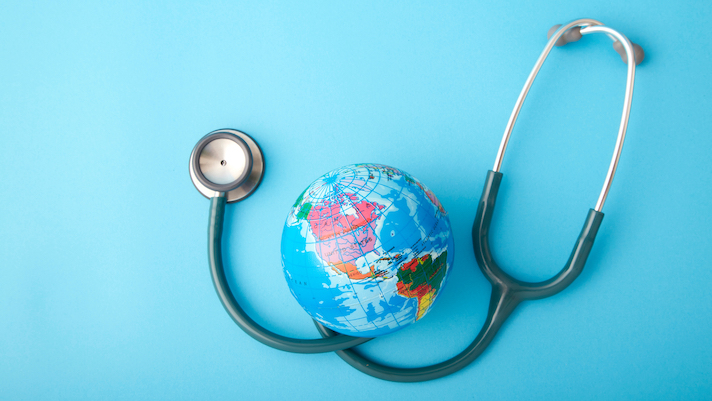

#**Introduction**
For individuals, having good health directly leads to a more productive and happier life. At a macro level, health and the economy are inextricaly linked as well with evidence showing that investing in health and health systems benefits economic status.

Our project aims to identify opportunities to invest in health with country level analysis. We use life expectancy, one of the most frequently used health indicator suggested by WHO, as as indicator for overall health status at a country and look for what levers have most significant positive impact on people’s life expectancy across countries. We use comprehensive data depicting 200+ characteristics from different countries to develop various ML models including K-Means clustering, PCA, and regression analysis. We would like to 1. Segregate countries into groups based on their health characteristics 2. Understand which health indicators have the most impact on life expectancy and if it differs by developed vs. developing countries and 3. develop a machine learning model to predict the life expectancy of a country based on changes in other factors. 

We would also like to explore other topics that interests us personally, or referenced in prior researches. For example, we would like to know if females with more babies live longer, and which country has seen the biggest improvement in life expectancy over the past 10 years. 

This project allows policy makers on determine where to invest public resources to maximize the benefit in people's health as measured by life expectancy.

The souerce of data is from Kaggle: https://www.kaggle.com/datasets/theworldbank/health-nutrition-and-population-statistics. The dataset contains 89,010 entries, where each data record is constituted of 58 columns. 

# Import Libraries

In [1]:
# suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Visualization libraries
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import plotly.offline as py
!pip install country_converter
import country_converter as coco
import missingno as msno

# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split

# to process time-series data
import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 339 kB/s 
  Created wheel for country-converter: filename=country_converter-0.8.0-py3-none-any.whl size=55657 sha256=78b552b922c186ac78a140975a1110dac44b282d775834af1c355479b2efcfa9
  Stored in directory: /root/.cache/pip/wheels/c2/5a/f6/7187fa51e18f2ed105833a7f5c44a2475ace0c96e19118e608
Successfully built country-converter


#Data Imports

In [2]:
!apt update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.c

In [3]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 4.9 MB/s 


In [6]:
# Create the kaggle directory and read the uploaded kaggle.json file
!mkdir ~/.kaggle

In [7]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [8]:
# Download dataset
!!kaggle datasets download -d theworldbank/health-nutrition-and-population-statistics

['Downloading health-nutrition-and-population-statistics.zip to /content',
 '',
 '  0% 0.00/14.0M [00:00<?, ?B/s]',
 ' 64% 9.00M/14.0M [00:00<00:00, 73.2MB/s]',
 '',
 '100% 14.0M/14.0M [00:00<00:00, 100MB/s] ']

In [9]:
# Unzip folder in Colab content folder
!unzip /content/health-nutrition-and-population-statistics.zip

Archive:  /content/health-nutrition-and-population-statistics.zip
  inflating: data.csv                


In [10]:
df = pd.read_csv("data.csv")

# Check out the first five rows
df.head(5)

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name     Indicator Code  \
0  % of females ages 15-49 having comprehensive c...  SH.HIV.KNOW.FE.ZS   
1  % of males ages 15-49 having comprehensive cor...  SH.HIV.KNOW.MA.ZS   
2  Adolescent fertility rate (births per 1,000 wo...        SP.ADO.TFRT   
3  Adults (ages 15+) and children (0-14 years) li...        SH.HIV.TOTL   
4  Adults (ages 15+) and children (ages 0-14) new...     SH.HIV.INCD.TL   

         1960        1961        1962        1963        1964        1965  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2  133.555013  134.159119  134.857912  134.504576  134.105211  133.569626   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   ...       2007       2008       2009       2010       2011       2012  \
0  ...        NaN        NaN        NaN        NaN        NaN        NaN   
1  ...        NaN        NaN        NaN        NaN        NaN        NaN   
2  ...  49.999851  49.887046  49.781207  49.672975  49.536047  49.383745   
3  ...        NaN        NaN        NaN        NaN        NaN        NaN   
4  ...        NaN        NaN        NaN        NaN        NaN        NaN   

        2013       2014  2015  Unnamed: 60  
0        NaN        NaN   NaN          NaN  
1        NaN        NaN   NaN          NaN  
2  48.796558  48.196418   NaN          NaN  
3        NaN        NaN   NaN          NaN  
4        NaN        NaN   NaN          NaN  

[5 rows x 61 columns]

In [11]:
#Examine the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89010 entries, 0 to 89009
Data columns (total 61 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    89010 non-null  object 
 1   Country Code    89010 non-null  object 
 2   Indicator Name  89010 non-null  object 
 3   Indicator Code  89010 non-null  object 
 4   1960            35482 non-null  float64
 5   1961            35325 non-null  float64
 6   1962            35889 non-null  float64
 7   1963            35452 non-null  float64
 8   1964            35483 non-null  float64
 9   1965            35603 non-null  float64
 10  1966            35538 non-null  float64
 11  1967            36022 non-null  float64
 12  1968            35577 non-null  float64
 13  1969            35630 non-null  float64
 14  1970            36910 non-null  float64
 15  1971            37578 non-null  float64
 16  1972            38015 non-null  float64
 17  1973            37542 non-null 

# Data Cleaning

To enable country-level analysis, we transposed the dataframe from long to wide. We also created a snapshot view with 2014 data, since it has more complete data compared to the latest year fo 2015. For the analysis, we removed data with more than 75% null values.

In [12]:
#Change the column names to lower case and replace the " " with "_"
df = df.rename(columns=str.lower)
df.columns = df.columns.str.replace(' ', '_')

In [13]:
#Drop unneeded columns
df = df.drop(columns=['country_code', 'indicator_code', 'unnamed:_60'])
#Drop duplicates
df = df[~df.duplicated()]

In [14]:
#Select 2014 and 2004 as our data, comparing the dimensions for each country
df_2004_2014 = df[['indicator_name','country_name','2014', '2004']]

#Drop rows with null values 
df_2004_2014 = df_2004_2014.dropna()

#Construct df_2004
df_2004 = df_2004_2014[['indicator_name', 'country_name', '2004']]
#Construct df_2014
df_2014 = df_2004_2014[['indicator_name', 'country_name', '2014']]

In [15]:
#Transpose df_2004
columns = df_2004.indicator_name.unique()

#Reshape from long to wide
df_2004_wide=pd.pivot(df_2004, index=['country_name'], columns = 'indicator_name',values = '2004') 
#Reset Index
df_2004_wide = df_2004_wide.reset_index()

#Transpose df_2014
columns = df_2004.indicator_name.unique()

#Reshape from long to wide
df_2014_wide=pd.pivot(df_2014, index=['country_name'], columns = 'indicator_name',values = '2014') 
#Reset Index
df_2014_wide = df_2014_wide.reset_index()


In [16]:
#Drop the columns(indicators) which have greater than 75% null values
#2004
perc = 75.0
min_count =  int(((100-perc)/100)*df_2004_wide.shape[0] + 1)
df_2004_wide = df_2004_wide.dropna(axis=1, thresh=min_count)

#2014
perc = 75.0
min_count =  int(((100-perc)/100)*df_2014_wide.shape[0] + 1)
df_2014_wide = df_2014_wide.dropna(axis=1, thresh=min_count)

A closer look at the dataframe revealed that the dataset has both country level and region level data points. To remove noise, we identified and dropped 47 rows not for a specific country.

In [17]:
#drop rows not related to a specific country
drop_list=[
'Arab World',
'Caribbean small states',
'Channel Islands' ,
'Early-demographic dividend' ,
'East Asia & Pacific', 
'East Asia & Pacific (' ,
'Fragile and conflict affected situations' ,
'Heavily indebted poor countries (HIPC)' ,
'Latin America & Caribbean' ,
'Latin America & Caribbean (' ,
'Latin America & the Caribbean (IDA & IBRD countries)', 
'Least developed countries: UN classification' ,
'Low & middle income' ,
'Low income' ,
'Lower middle income' ,
'Middle East & North Africa' ,
'Middle East & North Africa (IDA & IBRD countries)' ,
'Middle East & North Africa (' ,
'Middle income' ,
'Pre-demographic dividend' ,
'South Asia' ,
'South Asia (IDA & IBRD)' ,
'Sub-Saharan Africa' ,
'Sub-Saharan Africa (IDA & IBRD countries)' 
'Sub-Saharan Africa (' ,
'Upper middle income' ,
'World',
'North America', 
'High income',
'Post-demographic dividend',
'OECD members',
'Latin America & Caribbean (',
'Euro area',
'European Union',
'Europe & Central Asia',
'Europe & Central Asia (',
'Europe & Central Asia (IDA & IBRD countries)',
'Central Europe and the Baltics',
'Middle East & North Africa (',
'Late-demographic dividend',
'Other small states',
'Small states',
'East Asia & Pacific (',
'East Asia & Pacific (IDA & IBRD countries)',
'Pacific island small states',
'Sub-Saharan Africa (IDA & IBRD countries)',
'Sub-Saharan Africa ('
'Latin America & Caribbean ('
]

df_2014_wide = df_2014_wide[df_2014_wide.country_name.isin(drop_list) == False]

df_2014_wide.shape

(221, 242)

#Exploratory Data Analysis

With 242 different features as shown above for each country, we first conducted exploratory analysis to look for patterns in the data. Specifically, we categorized the features into 3 main categories, including 1) demographic and life expectancy, 2) education, economics, and infrastructure, and 3) health status, health expenditure, and preventative care to deep dive into each category. 

Afterwards, we also performed time-series analysis to look for patterns over the years.

##Part 1: Demographic and Life Expectancy



#####Demographic: Percentage of labor population

To understand the demographic distribution of each country, we plot a bar chart for each country, there red indicates ages 0-14, blue indicates ages 15-64, and green indicates ages 65+. Ranked from the lef to the right, are countries that are experiencing population aging and low fertility rate. The typical countries include Japan, EU countrys, Hong Kong, etc. On the right hand side of the spectrum are populations that are rapidly growing. Examples include Qatar, UAE, Afghanistan, etc.

In [18]:
demo_2004 = df_2004_wide[['country_name', 'Population ages 00-14 (% of total)', 'Population ages 15-64 (% of total)',
                          'Population ages 65 and above (% of total)']]

In [19]:
demo_2014 = df_2014_wide[['country_name', 'Population ages 00-14 (% of total)', 'Population ages 15-64 (% of total)',
                          'Population ages 65 and above (% of total)']]

Text(0.5, 1.0, 'Demographic Age Distribution 2004')

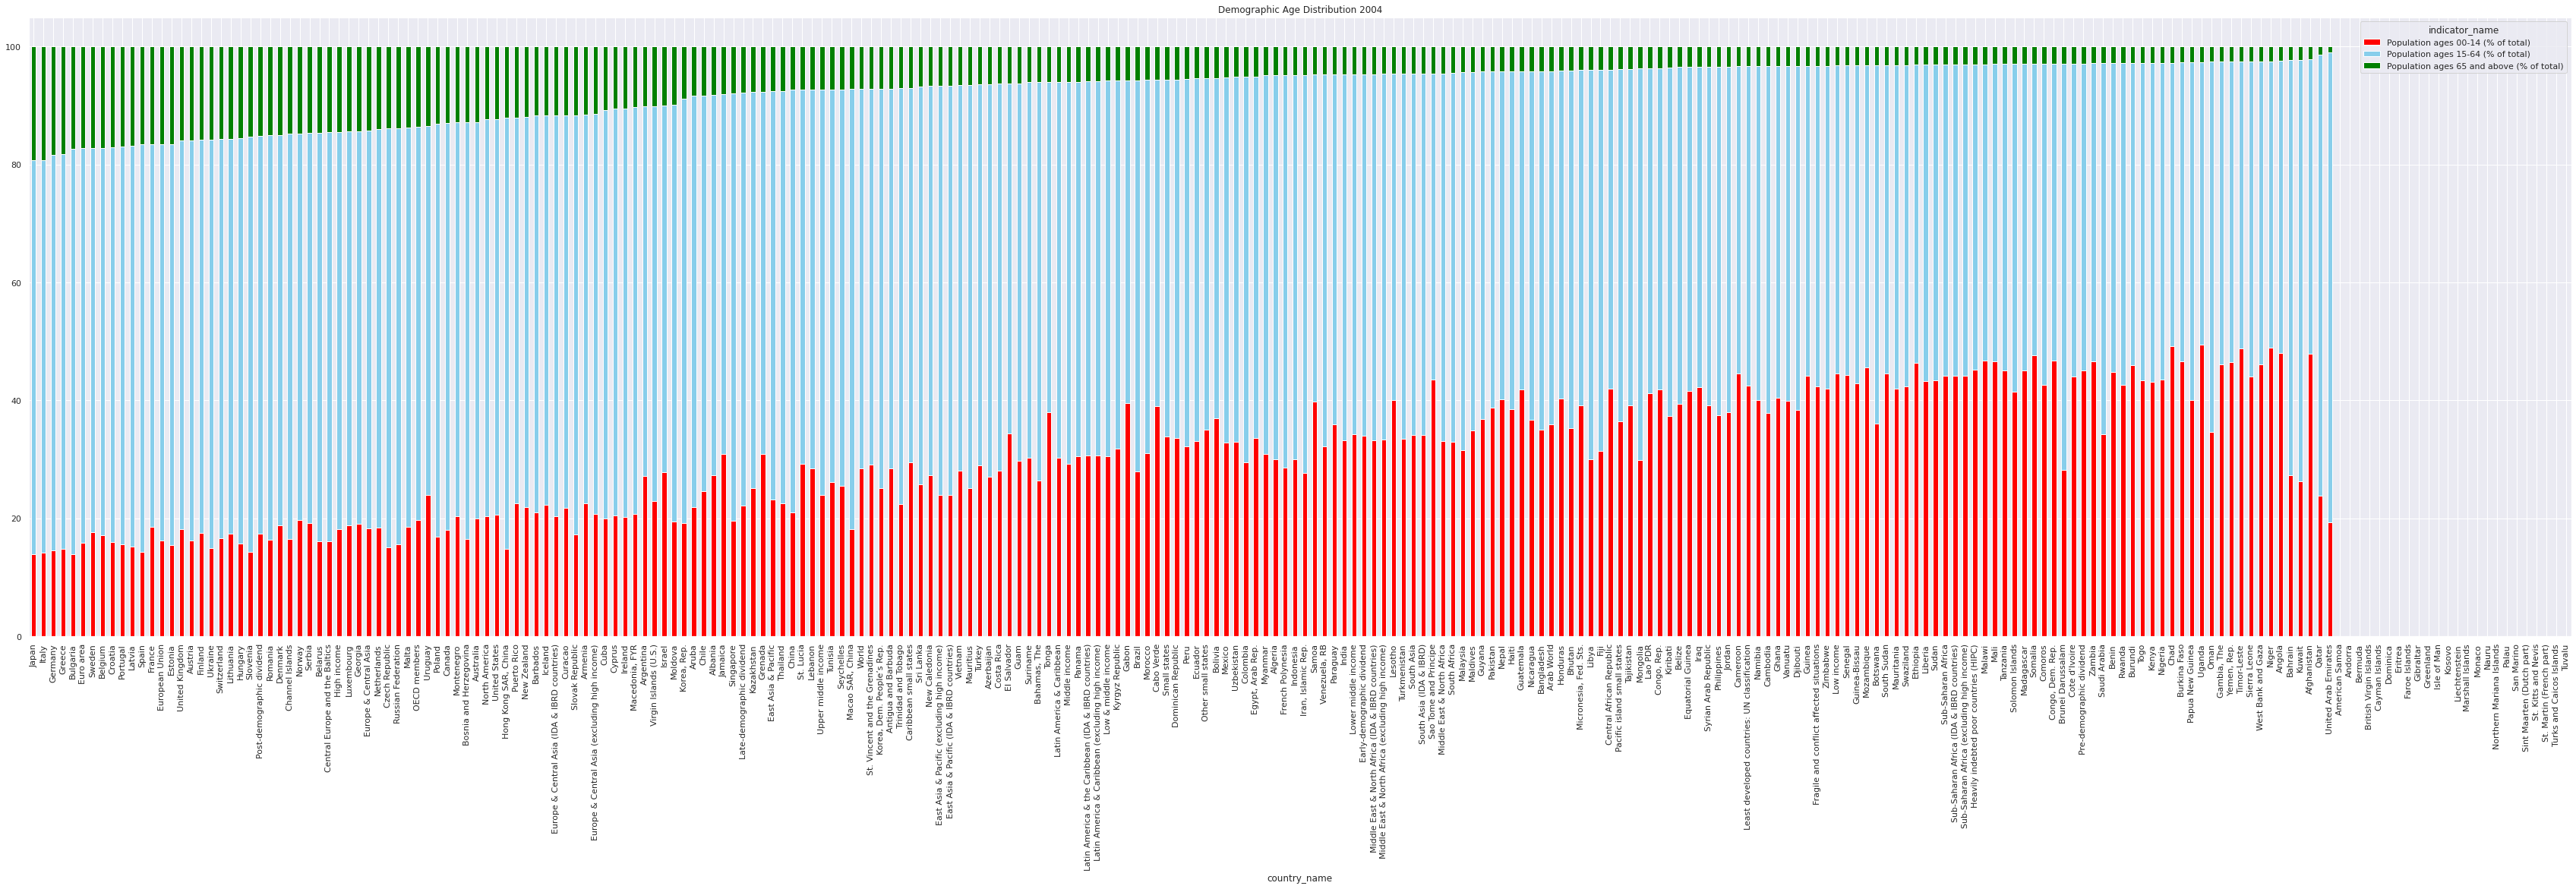

In [20]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(60, 15)})

demo_2004.sort_values('Population ages 65 and above (% of total)', 
                      ascending = False).set_index('country_name').plot(
                          kind='bar', stacked=True, color=['red', 'skyblue', 'green'])
plt.title('Demographic Age Distribution 2004')

Text(0.5, 1.0, 'Demographic Age Distribution 2014')

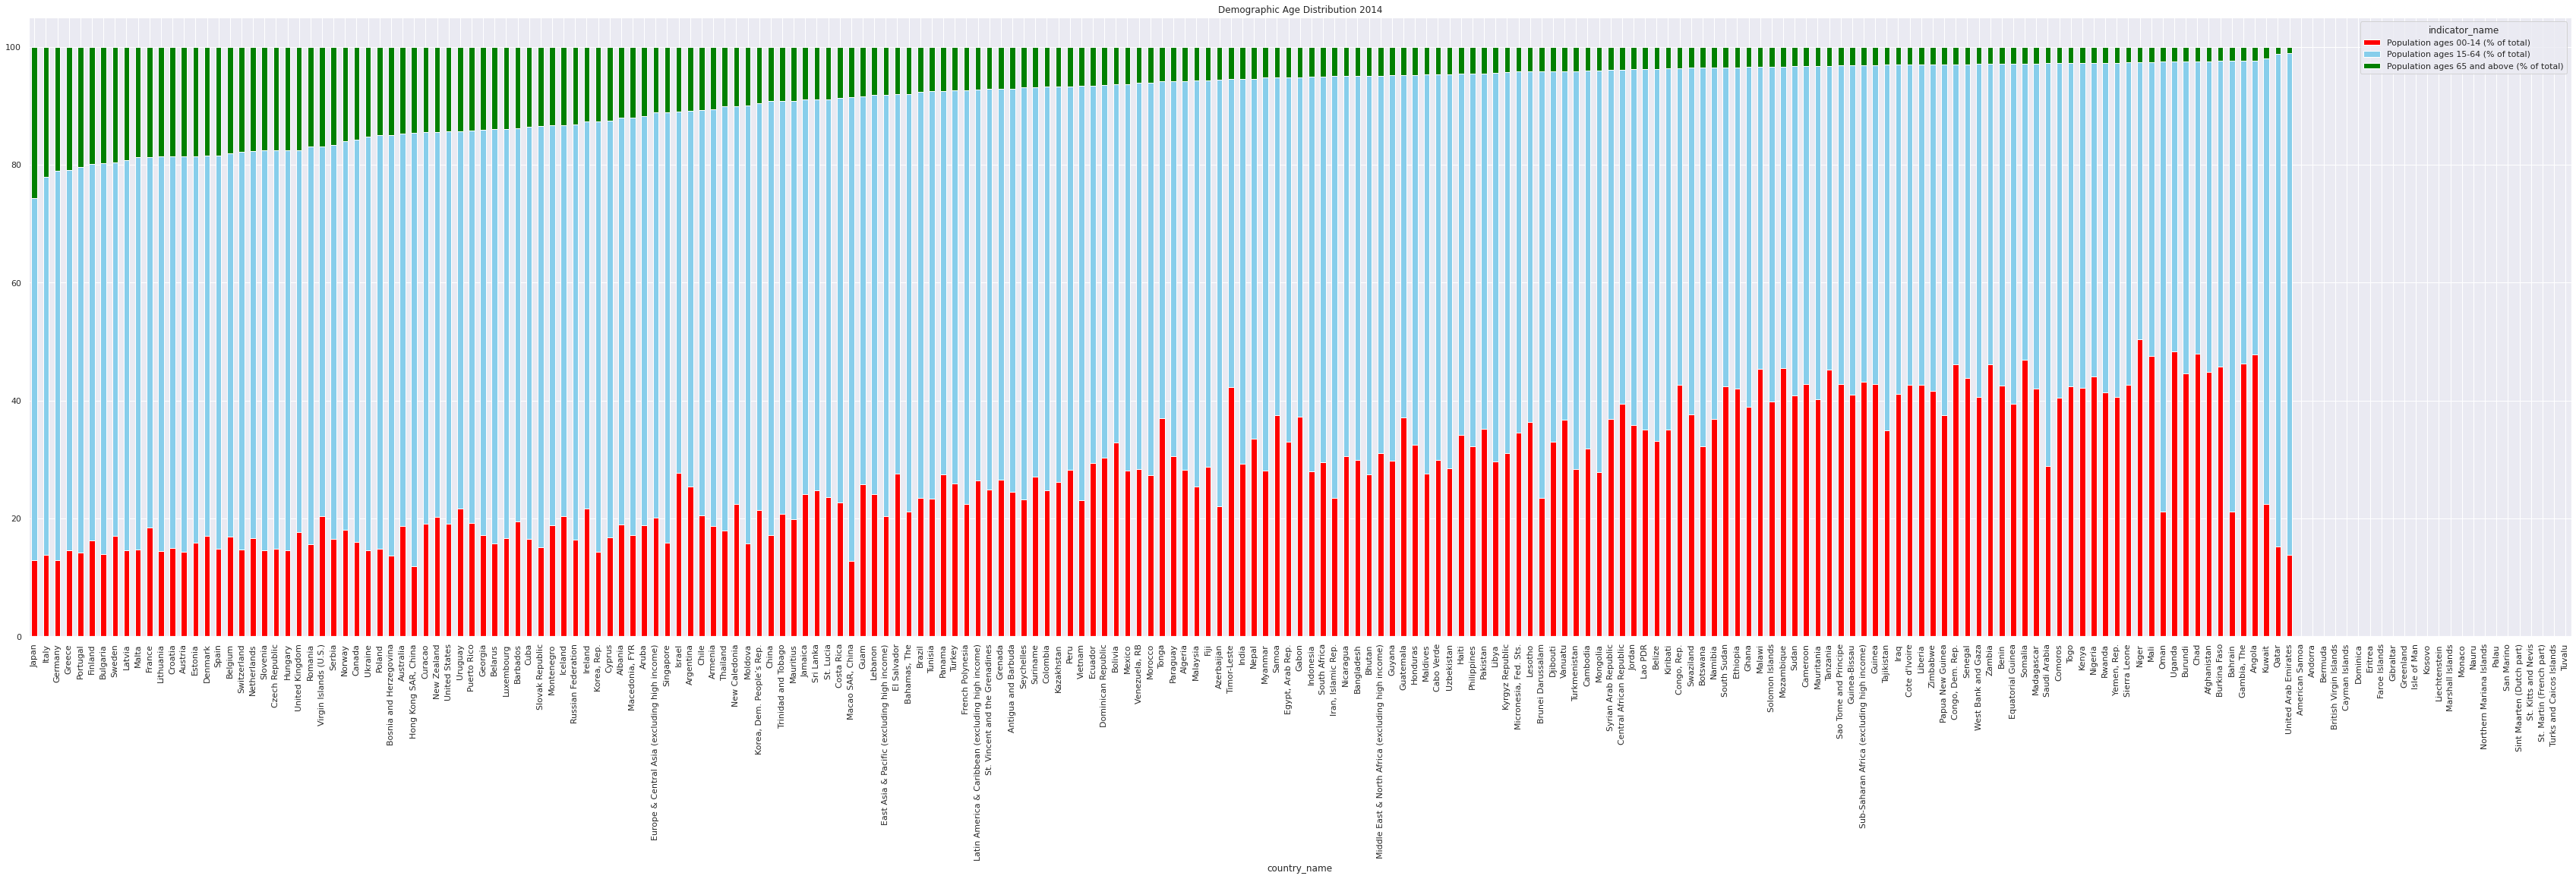

In [21]:
sns.set(rc={'figure.figsize':(60, 15)})

demo_2014.sort_values('Population ages 65 and above (% of total)', 
                      ascending = False).set_index('country_name').plot(
                          kind='bar', stacked=True, color=['red', 'skyblue', 'green'])
plt.title('Demographic Age Distribution 2014')

#####Labor force vs. the whole population

Then we look at the labor force as a percentage of the whole population, comparing two snapshot of time: 2004 and 2014. This chart shows the change of labor force as a % of the whole population in the these 10 years.

In [23]:
#Calculate the labor force as a percentage of the whole population
lf_2004 = df_2004_wide[['country_name', 'Labor force, total','Population, total']]
lf_2004['labor_perc'] = lf_2004['Labor force, total']/lf_2004['Population, total']
lf_2014 = df_2014_wide[['country_name', 'Labor force, total','Population, total']]
lf_2014['labor_perc'] = lf_2014['Labor force, total']/lf_2014['Population, total']

<ipython-input-23-58b227b4c760>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-58b227b4c760>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
lf_2004_2014 = lf_2004.merge(lf_2014, on = 'country_name')
lf_2004_2014 = lf_2004_2014[['country_name','labor_perc_x', 'labor_perc_y']].rename(
    columns = {'labor_perc_x':'labor_perc_2004', 'labor_perc_y':'labor_perc_2014'} )

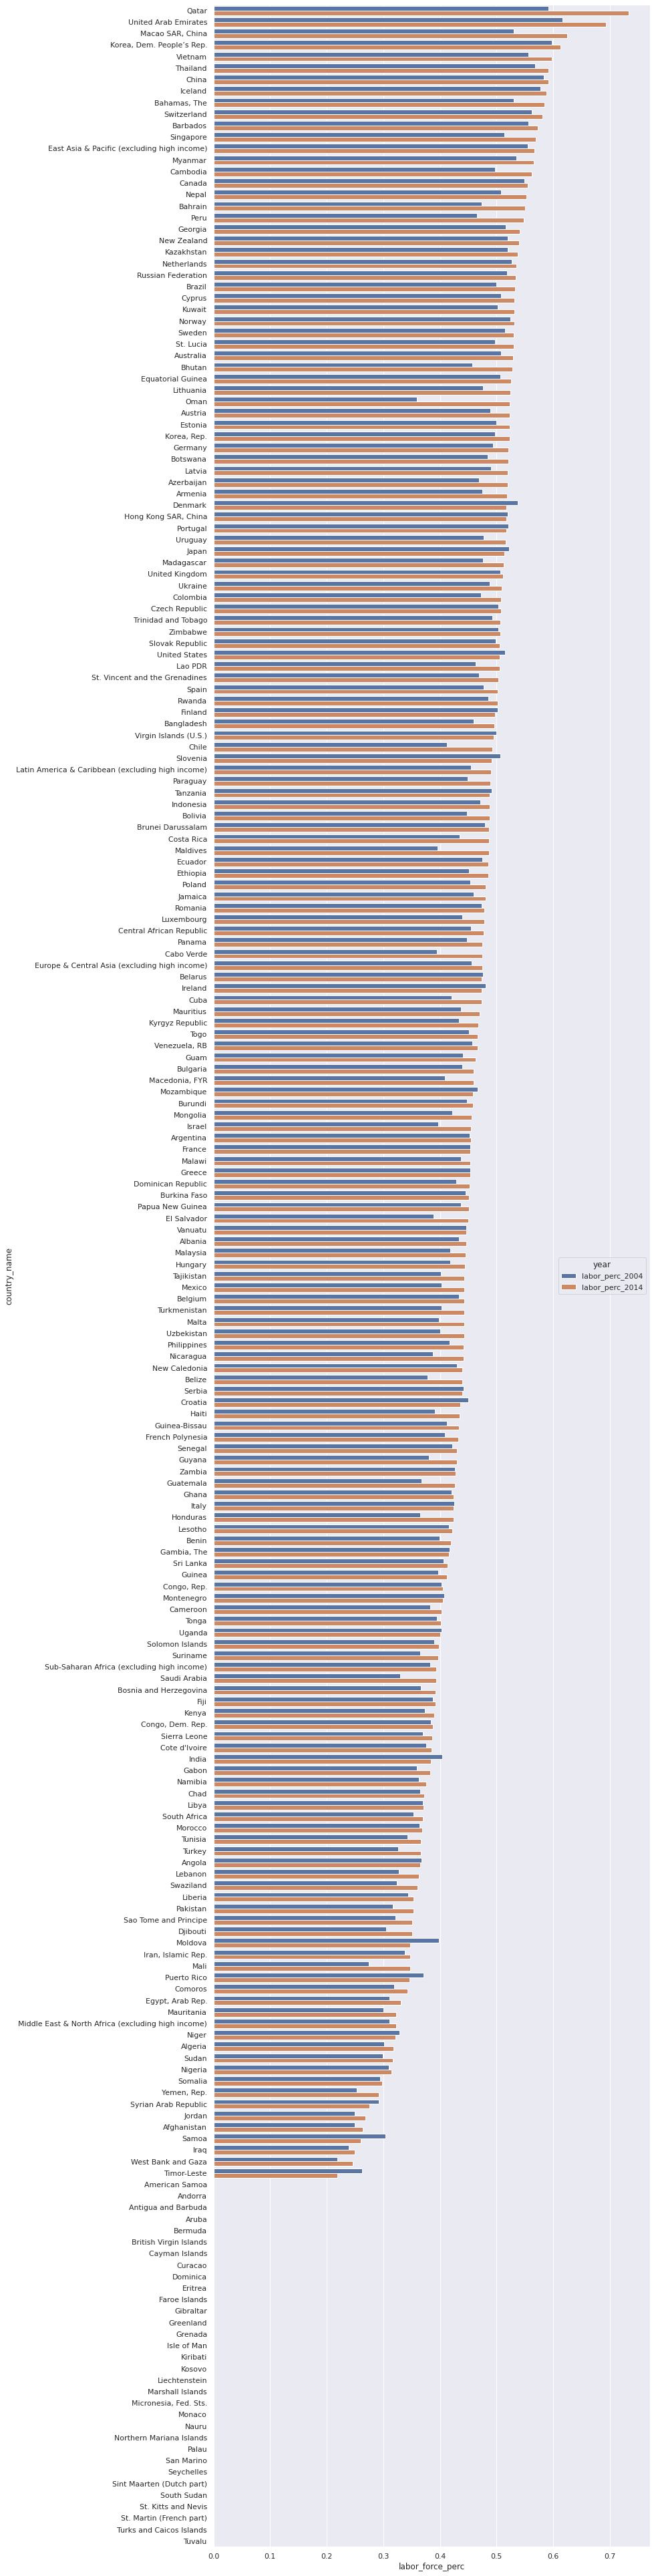

In [25]:
# Convert the dataframe to long
lf_2004_2014_long = lf_2004_2014.melt('country_name', var_name='year', value_name='labor_force_perc')
# # who v/s fare barplot
sns.set(rc={'figure.figsize':(11.7, 70)})
sns.barplot(x = 'labor_force_perc',
            y = 'country_name',
            hue = 'year',
            data = lf_2004_2014_long,
            order = lf_2004_2014_long[lf_2004_2014_long['year'] == 'labor_perc_2014'].sort_values(
                'labor_force_perc', ascending = False).country_name)
 
# Show the plot
plt.show()

##### Ploting the life expectancy chart for all countrys, comparing 2004 and 2014


Similarly, we compare the life expectancty of each country in 2004 and 2014. The majority of countries have incresed life expectancy, but the magnitude of the improvement varies.

In [26]:
#Set up a dataset for the Life Expectancy plot
le_2004 = df_2004_wide[['country_name', 'Life expectancy at birth, total (years)']]
le_2004 = le_2004.rename(columns = {'Life expectancy at birth, total (years)':'le_2004'})
le_2014 = df_2014_wide[['country_name', 'Life expectancy at birth, total (years)']]  
le_2014 = le_2014.rename(columns = {'Life expectancy at birth, total (years)':'le_2014'})
le_df = le_2004.merge(le_2014, on = 'country_name')

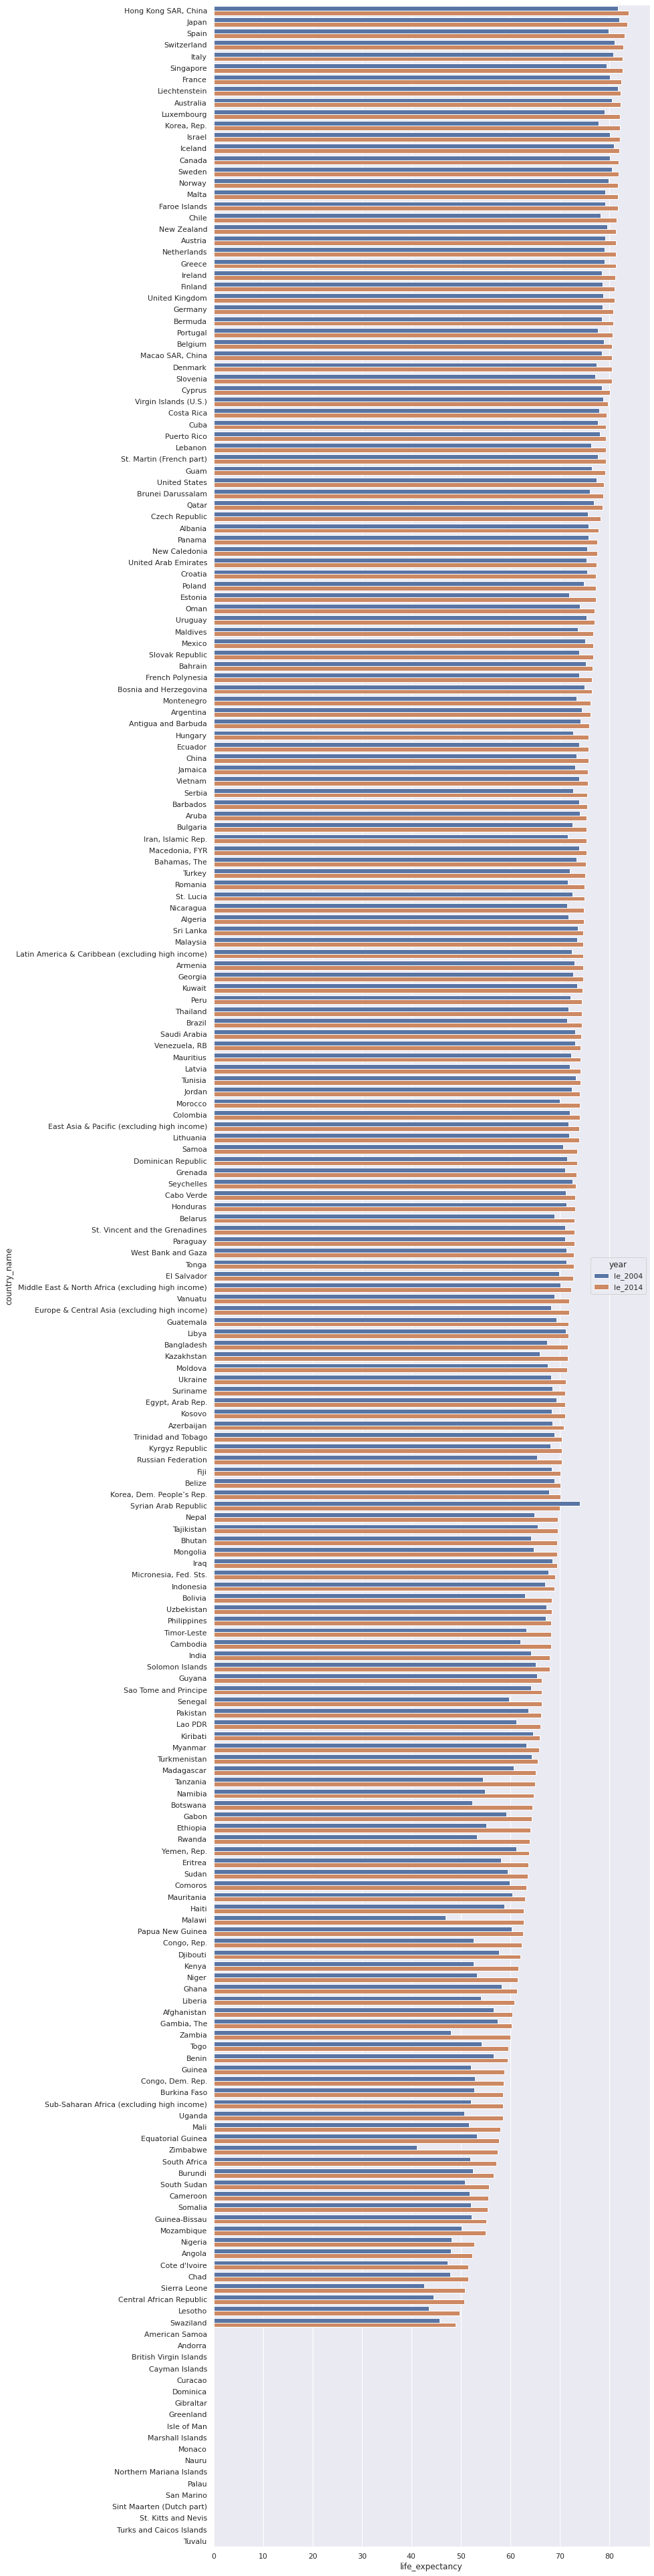

In [27]:
#Plot life expectancy for each country
 
# Convert the dataframe to long
le_df_long = le_df.melt('country_name', var_name='year', value_name='life_expectancy')
# # who v/s fare barplot
sns.set(rc={'figure.figsize':(11.7, 70)})
sns.barplot(x = 'life_expectancy',
            y = 'country_name',
            hue = 'year',
            data = le_df_long, 
            order = le_df_long[le_df_long['year'] == 'le_2014'].sort_values(
                'life_expectancy', ascending = False).country_name)
 
# Show the plot
plt.show()

#####Which country has had the biggest improvement in life expectancy over the 10 years? 

In [28]:
#Calculate the change in life expectancy
le_df['le_diff_perc'] = le_df['le_2014']/le_df['le_2004'] - 1
le_df = le_df.sort_values('le_diff_perc', ascending = False)
le_df.head(10)

indicator_name  country_name    le_2004    le_2014  le_diff_perc
220                 Zimbabwe  41.059341  57.498317      0.400371
121                   Malawi  46.957341  62.721634      0.335715
219                   Zambia  47.932390  60.047049      0.252745
25                  Botswana  52.356317  64.429244      0.230592
164                   Rwanda  53.197634  63.965659      0.202415
195                 Tanzania  54.416244  64.943902      0.193465
172             Sierra Leone  42.639195  50.878780      0.193240
44               Congo, Rep.  52.598000  62.311146      0.184668
139                  Namibia  54.923463  64.680195      0.177642
101                    Kenya  52.552244  61.576366      0.171717

#####Which country has declined life expectancy? 

In [29]:
le_df = le_df.sort_values('le_diff_perc', ascending = True)
le_df.head(5)

indicator_name          country_name    le_2004    le_2014  le_diff_perc
193             Syrian Arab Republic  74.095683  70.071024     -0.054317
115                    Liechtenstein  81.770732  82.260976      0.005995
114                            Libya  71.276805  71.716122      0.006164
171                       Seychelles  72.609756  73.229268      0.008532
201                          Tunisia  73.302439  74.143902      0.011479

Syrian Arab Republic is the only country that has declined life expectancy over the 10 years.

## Part 2: Economic, Infrastructure, and Education

Economic, infrastructure, and education included characteristics like labor force participation, gross net income per cpaita, unemployment rate, urban population, and school enrollment status.

In this part, we examined overall pattern of economics status data and seek to answer a few questions of interst including: which countries are the wealthiest? what are the countries with highest and lowest unemployment rata? which countries have the highest level of urbanization? 

In [30]:
# create dataframe with variables related to economic status of the country
df_ec_2014 = df_2014_wide[['country_name',
                      'Labor force, female (% of total labor force)',
                      'Labor force, total',
                      'Unemployment, female (% of female labor force)',
                      'Unemployment, male (% of male labor force)',
                      'Unemployment, total (% of total labor force)', 'Urban population',
                      'Urban population (% of total)',
                      'Urban population growth (annual %)',
                      'GNI per capita, Atlas method (current US$)']]

df_ec_2004 = df_2004_wide[['country_name',
                      'Labor force, female (% of total labor force)',
                      'Labor force, total',
                      'Unemployment, female (% of female labor force)',
                      'Unemployment, male (% of male labor force)',
                      'Unemployment, total (% of total labor force)', 'Urban population',
                      'Urban population (% of total)',
                      'Urban population growth (annual %)',
                      'GNI per capita, Atlas method (current US$)']]

# clean up column names
df_ec_2014 = df_ec_2014.rename(columns = {'Labor force, female (% of total labor force)':'lf_female',
                                          'Labor force, total':'lf',
                                          'Unemployment, female (% of female labor force)':'ur_female',
                                          'Unemployment, male (% of male labor force)':'ur_male',
                                          'Unemployment, total (% of total labor force)':'ur', 
                                          'GNI per capita, Atlas method (current US$)':'GNI'
                                          })
df_ec_2004 = df_ec_2004.rename(columns = {'Labor force, female (% of total labor force)':'lf_female',
                                          'Labor force, total':'lf',
                                          'Unemployment, female (% of female labor force)':'ur_female',
                                          'Unemployment, male (% of male labor force)':'ur_male',
                                          'Unemployment, total (% of total labor force)':'ur', 
                                          'GNI per capita, Atlas method (current US$)':'GNI'
                                          })

# create merged df with both years
df_ec = df_ec_2004.merge(df_ec_2014, on = 'country_name')

In [31]:
# create dataframe with variables related to infrastructure of the country
df_infra_2014 = df_2014_wide[['country_name',
                            'Improved sanitation facilities (% of population with access)',
                            'Improved water source (% of population with access)',
                            'People practicing open defecation (% of population)',
                            'Rural population (% of total population)',
                            'Urban population (% of total)']]
df_infra_2004 = df_2004_wide[['country_name',
                            'Improved sanitation facilities (% of population with access)',
                            'Improved water source (% of population with access)',
                            'People practicing open defecation (% of population)',
                            'Rural population (% of total population)',
                            'Urban population (% of total)']]
df_infra = df_infra_2004.merge(df_infra_2014, on = 'country_name')

# create dataframe with variables related to education
df_edu_2014 = df_2014_wide[['country_name',
                            "School enrollment, primary (% gross)",
                            "School enrollment, primary, female (% gross)",
                            "School enrollment, primary, male (% gross)"]]
df_edu_2004 = df_2004_wide[['country_name',
                            "School enrollment, primary (% gross)",
                            "School enrollment, primary, female (% gross)",
                            "School enrollment, primary, male (% gross)"]]
df_edu = df_edu_2004.merge(df_edu_2014, on = 'country_name')

Below is a table summarizing findings data patterns for economic status. Observations include: 1)

In [32]:
# check summary statistics of economic status
df_ec_2014.describe()

indicator_name   lf_female            lf   ur_female     ur_male          ur  \
count           189.000000  1.890000e+02  179.000000  179.000000  179.000000   
mean             41.016543  2.916834e+07   10.110332    7.847945    8.564794   
std               9.087176  1.139150e+08    7.662515    5.671784    6.074483   
min              13.116764  4.239000e+04    0.400000    0.100000    0.300000   
25%              38.165222  1.236917e+06    4.800000    3.900000    4.400000   
50%              44.120912  4.444955e+06    7.600000    6.400000    6.900000   
75%              47.097880  1.247475e+07   12.650000    9.550000   10.850000   
max              53.950674  1.145225e+09   39.200001   31.500000   31.000000   

indicator_name  Urban population  Urban population (% of total)  \
count               2.180000e+02                     218.000000   
mean                2.857308e+07                      59.376985   
std                 1.037086e+08                      24.119424   
min                 5.334000e+03                       8.550000   
25%                 3.994805e+05                      39.651000   
50%                 3.570926e+06                      59.335500   
75%                 1.111525e+07                      78.818000   
max                 1.049724e+09                     100.000000   

indicator_name  Urban population growth (annual %)            GNI  
count                                   218.000000     183.000000  
mean                                      1.913555   13829.194944  
std                                       1.759146   19625.954071  
min                                      -4.811074     270.000000  
25%                                       0.706579    1885.000000  
50%                                       1.698476    5780.000000  
75%                                       3.072485   14910.000000  
max                                       8.711149  105810.000000

Below pairplot summarizes the correlation between the features for infrastructure variables.

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



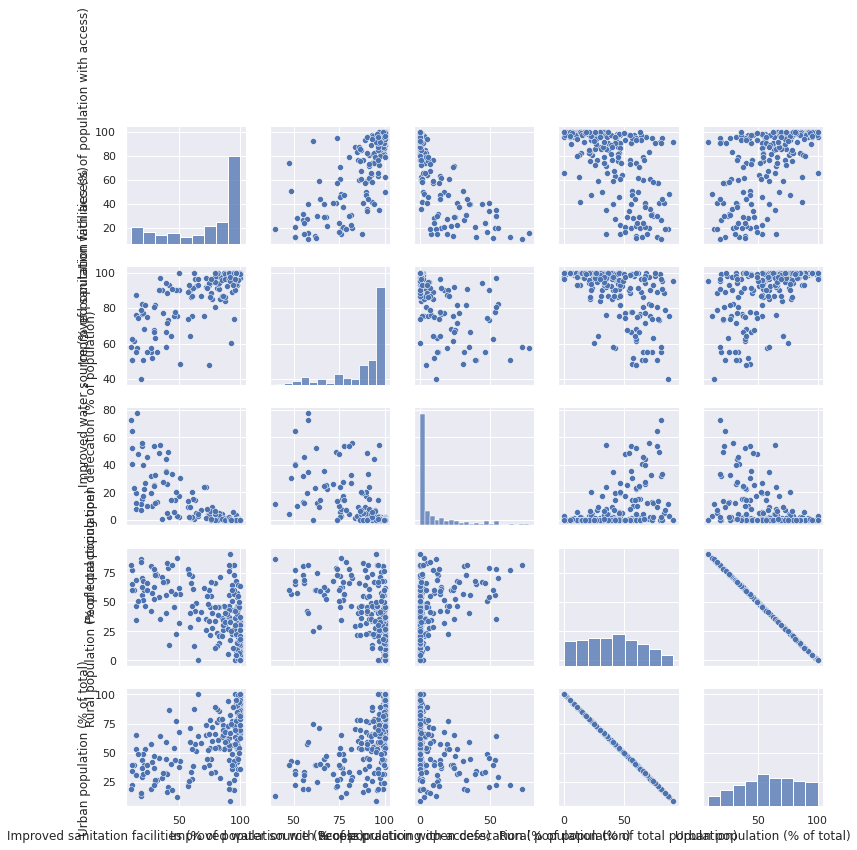

In [33]:
sns.pairplot(df_infra_2014, kind = "scatter")

### Which countries are the wealthiest?

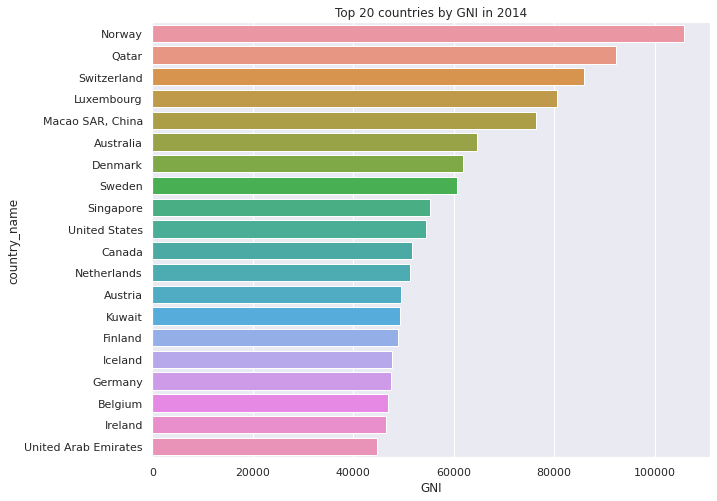

In [34]:
# plot top 50 countries by GNI
df_ec_2014 = df_ec_2014.sort_values('GNI', ascending = False)
df_ec_2014_top20 = df_ec_2014.head(20)
sns.set(rc={'figure.figsize':(10, 8)})
sns.barplot(x = 'GNI',
            y = 'country_name',
            data = df_ec_2014_top20)
plt.title("Top 20 countries by GNI in 2014")
plt.show()

### What are the countries with highest and lowest unemployment rate?

Mauritania has the highest unemployment rate in 2014 at 31% with male unemployment rate slightly higher than female unemployment rate.

In [35]:
# create different in male and female unemployment rate
df_ec_2014['ur_diff'] = df_ec_2014['ur_male'] - df_ec_2014['ur_female']

#top 10 countries with the largest different in male and female UR
df_ec_2014 = df_ec_2014 = df_ec_2014.sort_values('ur', ascending = False)
df_ec_2014[['country_name','ur','ur_male','ur_female']].head(10)

indicator_name            country_name         ur    ur_male  ur_female
148                         Mauritania  31.000000  31.500000  29.500000
25              Bosnia and Herzegovina  27.900000  26.700001  29.799999
140                     Macedonia, FYR  27.900000  27.700001  28.100000
88                              Greece  26.299999  22.600000  31.400000
130                            Lesotho  26.200001  21.299999  32.099998
253                 West Bank and Gaza  26.200001  26.700001  23.900000
210                       South Africa  25.100000  23.000000  27.600000
214                              Spain  24.700001  23.700001  26.000000
161                         Mozambique  22.600000  19.799999  25.000000
225                          Swaziland  22.299999  20.299999  25.500000

4 countries have unemployment rate lower than 1% including Qatar, Cambodia, Rwanda, and Thailand. 

In [36]:
#bottome 10 countries with the largest different in male and female UR
df_ec_2014 = df_ec_2014 = df_ec_2014.sort_values('ur', ascending = True)
df_ec_2014[['country_name','ur','ur_male','ur_female']].head(10)

indicator_name      country_name   ur  ur_male  ur_female
191                        Qatar  0.3      0.1        1.9
34                      Cambodia  0.4      0.4        0.4
194                       Rwanda  0.6      0.8        0.4
231                     Thailand  0.9      0.9        0.9
21                         Benin  1.0      1.1        1.0
122                      Lao PDR  1.4      1.6        1.2
139             Macao SAR, China  1.5      1.6        1.4
93                        Guinea  1.8      2.0        1.6
143                     Malaysia  2.0      1.8        2.2
251                      Vietnam  2.3      2.0        2.5

We observed high difference between male and female unemployment. Yemem, Syrian, Egypt, and Saudia Arabia are the top 4 coutnries with more than 15% different between male and female unemployment rate.

In [37]:
#top 10 countries with the largest different in male and female UR
df_ec_2014 = df_ec_2014 = df_ec_2014.sort_values('ur_diff', ascending = True)
df_ec_2014[['country_name','ur','ur_diff']].head(10)

indicator_name                                       country_name         ur  \
255                                                   Yemen, Rep.  17.400000   
228                                          Syrian Arab Republic  10.800000   
65                                               Egypt, Arab Rep.  13.200000   
198                                                  Saudi Arabia   5.600000   
59                                             Dominican Republic  15.000000   
20                                                         Belize  11.500000   
132                                                         Libya  19.200001   
154             Middle East & North Africa (excluding high inc...  12.884020   
144                                                      Maldives  11.600000   
82                                                          Gabon  19.700001   

indicator_name    ur_diff  
255            -29.400001  
228            -20.600001  
65             -19.299999  
198            -17.100001  
59             -13.900000  
20             -13.200001  
132            -12.500000  
154            -12.369425  
144            -11.700000  
82             -11.199999

In [38]:
# add geo code
df_ec_2014['country_code'] = df_infra_2014.country_name.apply(lambda x: coco.convert(names=x, to='ISO3', not_found=None))

The interactive heatmap below shows unemployment rate by country. 

In [39]:
fig = px.choropleth(df_ec_2014, locations="country_code",
                    color='GNI', 
                    hover_name="country_name", 
                    title = "GDP per Capita by Country 2014")
fig.show()

### Which countries have highest level of urbanization?

9 countries / regions have 100% population in urban areas as shown below:

In [40]:
#top 10 countries with highest urban populartion as % of total
df_infra_2014 = df_infra_2014 = df_infra_2014.sort_values('Urban population (% of total)', ascending = False)
df_infra_2014[['country_name','Urban population (% of total)']].head(10)

indicator_name               country_name  Urban population (% of total)
100                  Hong Kong SAR, China                        100.000
204             Sint Maarten (Dutch part)                        100.000
22                                Bermuda                        100.000
139                      Macao SAR, China                        100.000
164                                 Nauru                        100.000
38                         Cayman Islands                        100.000
203                             Singapore                        100.000
157                                Monaco                        100.000
87                              Gibraltar                        100.000
191                                 Qatar                         99.159

In [41]:
# add geo code
df_infra_2014['country_code'] = df_infra_2014.country_name.apply(lambda x: coco.convert(names=x, to='ISO3', not_found=None))

In [42]:
fig = px.choropleth(df_infra_2014, locations="country_code",
                    color='Urban population (% of total)', 
                    hover_name="country_name", 
                    title = "Urbanization Rate by Country in 2014")
fig.show()

From the heat map above, we can see that countries in North America and West Europe shows highest level of urbanization while countries in Africa and South Asia are behind with regard to percent of population living in urban areas.

### How do economic status, infrastructure, and education status correlate with each other?

In [43]:
# create correlation matrix
df_corr = df_2014_wide[['GNI per capita, Atlas method (current US$)',
                        'Labor force, female (% of total labor force)',
                        'Urban population (% of total)',
                        "School enrollment, primary (% gross)",
                        'Improved water source (% of population with access)']]
df_corr.corr()

indicator_name                                      GNI per capita, Atlas method (current US$)  \
indicator_name                                                                                   
GNI per capita, Atlas method (current US$)                                            1.000000   
Labor force, female (% of total labor force)                                          0.032633   
Urban population (% of total)                                                         0.612881   
School enrollment, primary (% gross)                                                 -0.122895   
Improved water source (% of population with acc...                                    0.432572   

indicator_name                                      Labor force, female (% of total labor force)  \
indicator_name                                                                                     
GNI per capita, Atlas method (current US$)                                              0.032633   
Labor force, female (% of total labor force)                                            1.000000   
Urban population (% of total)                                                          -0.127909   
School enrollment, primary (% gross)                                                    0.129855   
Improved water source (% of population with acc...                                     -0.094897   

indicator_name                                      Urban population (% of total)  \
indicator_name                                                                      
GNI per capita, Atlas method (current US$)                               0.612881   
Labor force, female (% of total labor force)                            -0.127909   
Urban population (% of total)                                            1.000000   
School enrollment, primary (% gross)                                    -0.178678   
Improved water source (% of population with acc...                       0.522666   

indicator_name                                      School enrollment, primary (% gross)  \
indicator_name                                                                             
GNI per capita, Atlas method (current US$)                                     -0.122895   
Labor force, female (% of total labor force)                                    0.129855   
Urban population (% of total)                                                  -0.178678   
School enrollment, primary (% gross)                                            1.000000   
Improved water source (% of population with acc...                             -0.140167   

indicator_name                                      Improved water source (% of population with access)  
indicator_name                                                                                           
GNI per capita, Atlas method (current US$)                                                   0.432572    
Labor force, female (% of total labor force)                                                -0.094897    
Urban population (% of total)                                                                0.522666    
School enrollment, primary (% gross)                                                        -0.140167    
Improved water source (% of population with acc...                                           1.000000

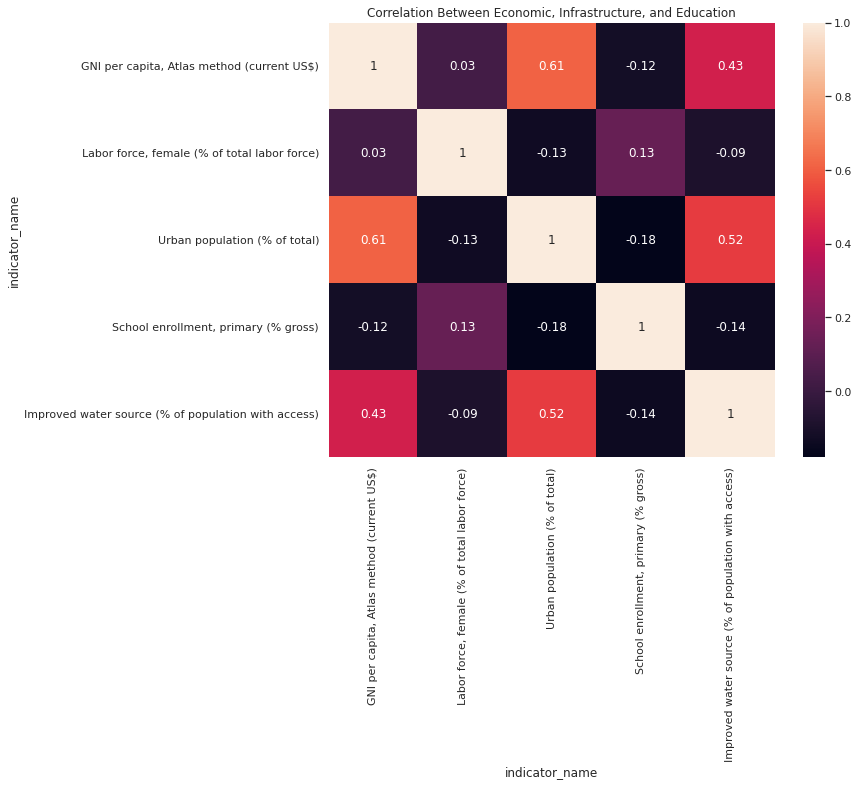

In [44]:
#visualiza the correlation matrix
matrix = df_corr.corr().round(2)
sns.set(rc={'figure.figsize':(10, 8)})
sns.heatmap(matrix, annot=True)
plt.title('Correlation Between Economic, Infrastructure, and Education')
plt.show()

Based on the correlation matrix, we can strong positive correlaion between GDP per capital and urbanization as well as between urbanizatoin and access to water. 

## Part 3: Health Status, Health Expenditure, and Preventive Care

In [46]:
# create dataframe with variables related to health status of the country
df_HS_2014 = df_2014_wide[['country_name','AIDS estimated deaths (UNAIDS estimates)','Adolescent fertility rate (births per 1,000 women ages 15-19)',
                           'Adults (ages 15+) and children (0-14 years) living with HIV',
                           'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
                           'Adults (ages 15+) living with HIV',
                           'Adults (ages 15+) newly infected with HIV',
                           'Birth rate, crude (per 1,000 people)',
                           'Children (0-14) living with HIV',
                           'Children (ages 0-14) newly infected with HIV',
                           'Children orphaned by HIV/AIDS',
                           "Women's share of population ages 15+ living with HIV (%)",
                           'Death rate, crude (per 1,000 people)',
                           'Fertility rate, total (births per woman)',
                           'Incidence of HIV (% of uninfected population ages 15-49)',
                           'Incidence of tuberculosis (per 100,000 people)',
                           'Lifetime risk of maternal death (%)',
                           'Lifetime risk of maternal death (1 in: rate varies by country)',
                           'Malaria cases reported', 
                           'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                           'Mortality rate, adult, female (per 1,000 female adults)',
                           'Mortality rate, adult, male (per 1,000 male adults)',
                           'Mortality rate, infant (per 1,000 live births)',
                           'Mortality rate, neonatal (per 1,000 live births)',
                           'Mortality rate, under-5 (per 1,000)',
                           'Number of infant deaths', 
                           'Number of maternal deaths',
                           'Number of neonatal deaths',
                           'Number of people who are undernourished',
                           'Number of under-five deaths','Prevalence of HIV, female (% ages 15-24)','Prevalence of HIV, male (% ages 15-24)',
                           'Prevalence of HIV, total (% of population ages 15-49)','Prevalence of tuberculosis (per 100,000 population)',
                           'Prevalence of undernourishment (% of population)',
                           'Survival to age 65, female (% of cohort)',
                           'Survival to age 65, male (% of cohort)',
                           'Tuberculosis case detection rate (all forms)',
                           'Tuberculosis death rate (per 100,000 people)']]

df_HS_2004 = df_2004_wide[['country_name','AIDS estimated deaths (UNAIDS estimates)','Adolescent fertility rate (births per 1,000 women ages 15-19)',
                           'Adults (ages 15+) and children (0-14 years) living with HIV',
                           'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
                           'Adults (ages 15+) living with HIV',
                           'Adults (ages 15+) newly infected with HIV',
                           'Birth rate, crude (per 1,000 people)',
                           'Children (0-14) living with HIV',
                           'Children (ages 0-14) newly infected with HIV',
                           'Children orphaned by HIV/AIDS',
                           "Women's share of population ages 15+ living with HIV (%)",
                           'Death rate, crude (per 1,000 people)',
                           'Fertility rate, total (births per woman)',
                           'Incidence of HIV (% of uninfected population ages 15-49)',
                           'Incidence of tuberculosis (per 100,000 people)',
                           'Lifetime risk of maternal death (%)',
                           'Lifetime risk of maternal death (1 in: rate varies by country)',
                           'Malaria cases reported', 
                           'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                           'Mortality rate, adult, female (per 1,000 female adults)',
                           'Mortality rate, adult, male (per 1,000 male adults)',
                           'Mortality rate, infant (per 1,000 live births)',
                           'Mortality rate, neonatal (per 1,000 live births)',
                           'Mortality rate, under-5 (per 1,000)',
                           'Number of infant deaths', 
                           'Number of maternal deaths',
                           'Number of neonatal deaths',
                           'Number of people who are undernourished',
                           'Number of under-five deaths','Prevalence of HIV, female (% ages 15-24)','Prevalence of HIV, male (% ages 15-24)',
                           'Prevalence of HIV, total (% of population ages 15-49)','Prevalence of tuberculosis (per 100,000 population)',
                           'Prevalence of undernourishment (% of population)',
                           'Survival to age 65, female (% of cohort)',
                           'Survival to age 65, male (% of cohort)',
                           'Tuberculosis case detection rate (all forms)',
                           'Tuberculosis death rate (per 100,000 people)']]

In [47]:
# create dataframe with variables related to preventative care of the country
df_PC_2014 = df_2014_wide[['country_name','Antiretroviral therapy coverage (% of people living with HIV)',
                           'Immunization, BCG (% of one-year-old children)',
                           'Immunization, DPT (% of children ages 12-23 months)',
                           'Immunization, HepB3 (% of one-year-old children)',
                           'Immunization, Hib3 (% of children ages 12-23 months)',
                           'Immunization, Pol3 (% of one-year-old children)',
                           'Immunization, measles (% of children ages 12-23 months)',
                           'Newborns protected against tetanus (%)',
                           ]]
df_PC_2004 = df_2004_wide[['country_name','Antiretroviral therapy coverage (% of people living with HIV)',
                           'Immunization, BCG (% of one-year-old children)',
                           'Immunization, DPT (% of children ages 12-23 months)',
                           'Immunization, HepB3 (% of one-year-old children)',
                           'Immunization, Hib3 (% of children ages 12-23 months)',
                           'Immunization, Pol3 (% of one-year-old children)',
                           'Immunization, measles (% of children ages 12-23 months)',
                           'Newborns protected against tetanus (%)',
                           ]]

In [48]:
# create dataframe with variables related to health expenditure of the country
df_HE_2014 = df_2014_wide[['country_name','Health expenditure per capita (current US$)',
       'Health expenditure per capita, PPP',
       'Health expenditure, private (% of GDP)',
       'Health expenditure, private (% of total health expenditure)',
       'Health expenditure, public (% of GDP)',
       'Health expenditure, public (% of government expenditure)',
       'Health expenditure, public (% of total health expenditure)',
       'Health expenditure, total (% of GDP)',
       'Health expenditure, total (current US$)',
       'Out-of-pocket health expenditure (% of private expenditure on health)',
       'Out-of-pocket health expenditure (% of total expenditure on health)',
                           ]]
df_HE_2004 = df_2004_wide[['country_name','Health expenditure per capita (current US$)',
       'Health expenditure per capita, PPP',
       'Health expenditure, private (% of GDP)',
       'Health expenditure, private (% of total health expenditure)',
       'Health expenditure, public (% of GDP)',
       'Health expenditure, public (% of government expenditure)',
       'Health expenditure, public (% of total health expenditure)',
       'Health expenditure, total (% of GDP)',
       'Health expenditure, total (current US$)',
       'Out-of-pocket health expenditure (% of private expenditure on health)',
       'Out-of-pocket health expenditure (% of total expenditure on health)',
                           ]]

In [49]:
# check summary statistics of health status
from google.colab.data_table import DataTable
DataTable.max_columns = 40

df_HS_2014.describe()
df_HS_2004.describe()

indicator_name  AIDS estimated deaths (UNAIDS estimates)  \
count                                       1.080000e+02   
mean                                        3.550556e+04   
std                                         1.964605e+05   
min                                         1.000000e+02   
25%                                         5.000000e+02   
50%                                         1.650000e+03   
75%                                         9.925000e+03   
max                                         2.000000e+06   

indicator_name  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
count                                                  235.000000               
mean                                                    57.855148               
std                                                     45.090913               
min                                                      0.834800               
25%                                                     20.490800               
50%                                                     46.612549               
75%                                                     83.659700               
max                                                    215.804000               

indicator_name  Adults (ages 15+) and children (0-14 years) living with HIV  \
count                                                1.080000e+02             
mean                                                 5.521537e+05             
std                                                  3.099051e+06             
min                                                  1.000000e+02             
25%                                                  9.225000e+03             
50%                                                  4.100000e+04             
75%                                                  1.725000e+05             
max                                                  3.150000e+07             

indicator_name  Adults (ages 15+) and children (ages 0-14) newly infected with HIV  \
count                                                1.080000e+02                    
mean                                                 4.599167e+04                    
std                                                  2.556103e+05                    
min                                                  1.000000e+02                    
25%                                                  1.000000e+03                    
50%                                                  4.300000e+03                    
75%                                                  1.400000e+04                    
max                                                  2.600000e+06                    

indicator_name  Adults (ages 15+) living with HIV  \
count                                1.080000e+02   
mean                                 5.133620e+05   
std                                  2.893650e+06   
min                                  1.000000e+02   
25%                                  9.125000e+03   
50%                                  3.950000e+04   
75%                                  1.525000e+05   
max                                  2.940000e+07   

indicator_name  Adults (ages 15+) newly infected with HIV  \
count                                        1.080000e+02   
mean                                         3.730370e+04   
std                                          2.067193e+05   
min                                          1.000000e+02   
25%                                          1.000000e+03   
50%                                          3.300000e+03   
75%                                          1.125000e+04   
max                                          2.100000e+06   

indicator_name  Birth rate, crude (per 1,000 people)  \
count                                     241.000000   
mean                                       23.016230   
std                                        11.

In [50]:
# Dropping number of deaths since we are performing cross country comparison. Each death number has a corresponding mortality rate number already present in df
df_HS_2014=df_HS_2014.drop(columns=['Number of infant deaths', 
                           'Number of maternal deaths',
                           'Number of neonatal deaths',
                           'Number of people who are undernourished',
                           'Number of under-five deaths',
                           'Lifetime risk of maternal death (1 in: rate varies by country)'])
df_HS_2004=df_HS_2004.drop(columns=['Number of infant deaths', 
                           'Number of maternal deaths',
                           'Number of neonatal deaths',
                           'Number of people who are undernourished',
                           'Number of under-five deaths',
                           'Lifetime risk of maternal death (1 in: rate varies by country)'])

In [51]:
# Calculate population data for number of adults (ages 15+) and children (0-14) by country
df_HS_2014['children'] = df_2014_wide['Population ages 00-14, total']
df_HS_2014['adult'] = df_2014_wide['Population ages 15-64, total']+ df_2014_wide['Population ages 65 and above, total']

df_HS_2004['children'] = df_2004_wide['Population ages 00-14, total']
df_HS_2004['adult'] = df_2004_wide['Population ages 15-64, total']+ df_2004_wide['Population ages 65 and above, total']

# Normalize data in the 10 columns 'AIDS estimated deaths (UNAIDS estimates)', 'Adults (ages 15+) and children (0-14 years) living with HIV', 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV', 
# 'Adults (ages 15+) living with HIV', 'Adults (ages 15+) newly infected with HIV', 'Children orphaned by HIV/AIDS' 
# 'Children (0-14) living with HIV','Children (ages 0-14) newly infected with HIV','Children orphaned by HIV/AIDS',
# 'Malaria cases reported' with population data
df_HS_2014['AIDS estimated deaths (UNAIDS estimates) (%)']=df_HS_2014['AIDS estimated deaths (UNAIDS estimates)']/(df_HS_2014['children']+df_HS_2014['adult'])*100
df_HS_2014['Adults (ages 15+) and children (0-14 years) living with HIV (%)']=df_HS_2014['Adults (ages 15+) and children (0-14 years) living with HIV']/(df_HS_2014['children']+df_HS_2014['adult'])*100
df_HS_2014['Adults (ages 15+) and children (ages 0-14) newly infected with HIV (%)']=df_HS_2014['Adults (ages 15+) and children (ages 0-14) newly infected with HIV']/(df_HS_2014['children']+df_HS_2014['adult'])*100
df_HS_2014['Adults (ages 15+) living with HIV (%)']=df_HS_2014['Adults (ages 15+) living with HIV']/(df_HS_2014['adult'])*100
df_HS_2014['Adults (ages 15+) newly infected with HIV (%)']=df_HS_2014['Adults (ages 15+) newly infected with HIV']/(df_HS_2014['adult'])*100
df_HS_2014['Children orphaned by HIV/AIDS (%)']=df_HS_2014['Children orphaned by HIV/AIDS']/(df_HS_2014['children'])*100
df_HS_2014['Children (0-14) living with HIV (%)']=df_HS_2014['Children (0-14) living with HIV']/(df_HS_2014['children'])*100
df_HS_2014['Children (ages 0-14) newly infected with HIV (%)']=df_HS_2014['Children (ages 0-14) newly infected with HIV']/(df_HS_2014['children'])*100
df_HS_2014['Children orphaned by HIV/AIDS (%)']=df_HS_2014['Children orphaned by HIV/AIDS']/(df_HS_2014['children'])*100
df_HS_2014['Malaria cases reported (%)']=df_HS_2014['Malaria cases reported']/(df_HS_2014['children']+df_HS_2014['adult'])*100

df_HS_2004['AIDS estimated deaths (UNAIDS estimates) (%)']=df_HS_2004['AIDS estimated deaths (UNAIDS estimates)']/(df_HS_2014['children']+df_HS_2014['adult'])*100
df_HS_2004['Adults (ages 15+) and children (0-14 years) living with HIV (%)']=df_HS_2004['Adults (ages 15+) and children (0-14 years) living with HIV']/(df_HS_2004['children']+df_HS_2004['adult'])*100
df_HS_2004['Adults (ages 15+) and children (ages 0-14) newly infected with HIV (%)']=df_HS_2004['Adults (ages 15+) and children (ages 0-14) newly infected with HIV']/(df_HS_2004['children']+df_HS_2004['adult'])*100
df_HS_2004['Adults (ages 15+) living with HIV (%)']=df_HS_2004['Adults (ages 15+) living with HIV']/(df_HS_2004['adult'])*100
df_HS_2004['Adults (ages 15+) newly infected with HIV (%)']=df_HS_2004['Adults (ages 15+) newly infected with HIV']/(df_HS_2004['adult'])*100
df_HS_2004['Children orphaned by HIV/AIDS (%)']=df_HS_2004['Children orphaned by HIV/AIDS']/(df_HS_2004['children'])*100
df_HS_2004['Children (0-14) living with HIV (%)']=df_HS_2004['Children (0-14) living with HIV']/(df_HS_2004['children'])*100
df_HS_2004['Children (ages 0-14) newly infected with HIV (%)']=df_HS_2004['Children (ages 0-14) newly infected with HIV']/(df_HS_2004['children'])*100
df_HS_2004['Children orphaned by HIV/AIDS (%)']=df_HS_2004['Children orphaned by HIV/AIDS']/(df_HS_2004['children'])*100
df_HS_2004['Malaria cases reported (%)']=df_HS_2004['Malaria cases reported']/(df_HS_2004['children']+df_HS_2004['adult'])*100


In [52]:
#drop intemediary columns (population data) and the 9 columns in numbers
df_HS_2014=df_HS_2014.drop(columns=['children', 'adult', 'AIDS estimated deaths (UNAIDS estimates)',
                           'Adults (ages 15+) and children (0-14 years) living with HIV', 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV', 
                           'Adults (ages 15+) living with HIV', 'Adults (ages 15+) newly infected with HIV', 'Children orphaned by HIV/AIDS',
                           'Children (0-14) living with HIV','Children (ages 0-14) newly infected with HIV','Children orphaned by HIV/AIDS'])

df_HS_2004=df_HS_2004.drop(columns=['children', 'adult','AIDS estimated deaths (UNAIDS estimates)',
                           'Adults (ages 15+) and children (0-14 years) living with HIV', 'Adults (ages 15+) and children (ages 0-14) newly infected with HIV', 
                           'Adults (ages 15+) living with HIV', 'Adults (ages 15+) newly infected with HIV', 'Children orphaned by HIV/AIDS',
                           'Children (0-14) living with HIV','Children (ages 0-14) newly infected with HIV','Children orphaned by HIV/AIDS',
                           'Malaria cases reported'])

In [53]:
df_HS_2014.describe()
df_HS_2004.describe()

indicator_name  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
count                                                  235.000000               
mean                                                    57.855148               
std                                                     45.090913               
min                                                      0.834800               
25%                                                     20.490800               
50%                                                     46.612549               
75%                                                     83.659700               
max                                                    215.804000               

indicator_name  Birth rate, crude (per 1,000 people)  \
count                                     241.000000   
mean                                       23.016230   
std                                        11.391019   
min                                         7.200000   
25%                                        13.160000   
50%                                        20.732357   
75%                                        29.647000   
max                                        51.884000   

indicator_name  Women's share of population ages 15+ living with HIV (%)  \
count                                                  127.000000          
mean                                                    41.818733          
std                                                     14.809663          
min                                                      3.797069          
25%                                                     30.050530          
50%                                                     41.741253          
75%                                                     56.589794          
max                                                     69.372642          

indicator_name  Death rate, crude (per 1,000 people)  \
count                                     241.000000   
mean                                        8.770124   
std                                         3.575510   
min                                         1.663000   
25%                                         6.152000   
50%                                         8.100000   
75%                                        10.617698   
max                                        20.251000   

indicator_name  Fertility rate, total (births per woman)  \
count                                         240.000000   
mean                                            3.055057   
std                                             1.627959   
min                                             0.827000   
25%                                             1.780000   
50%                                             2.529500   
75%                                             3.956500   
max                                             7.710000   

indicator_name  Incidence of HIV (% of uninfected population ages 15-49)  \
count                                                  124.000000          
mean                                                     0.253001          
std                                                      0.513632          
min                                                      0.010000          
25%                                                      0.020000          
50%                                                      0.060000          
75%                                                      0.232500          
max                                                      3.090000          

indicator_name  Incidence of tuberculosis (per 100,000 people)  \
count                                               224.000000   
mean                                                150.104241   
std                                                 205.614709   
min                                                   0.950000   
25%                

In [54]:
#Reflect above updates in df_2014_wide & df_2004_wide and save in df_2014_final & df_2004_final

temp_2014=df_2014_wide.drop(columns=['AIDS estimated deaths (UNAIDS estimates)','Adolescent fertility rate (births per 1,000 women ages 15-19)',
                           'Adults (ages 15+) and children (0-14 years) living with HIV',
                           'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
                           'Adults (ages 15+) living with HIV',
                           'Adults (ages 15+) newly infected with HIV',
                           'Birth rate, crude (per 1,000 people)',
                           'Children (0-14) living with HIV',
                           'Children (ages 0-14) newly infected with HIV',
                           'Children orphaned by HIV/AIDS',
                           "Women's share of population ages 15+ living with HIV (%)",
                           'Death rate, crude (per 1,000 people)',
                           'Fertility rate, total (births per woman)',
                           'Incidence of HIV (% of uninfected population ages 15-49)',
                           'Incidence of tuberculosis (per 100,000 people)',
                           'Lifetime risk of maternal death (%)',
                           'Lifetime risk of maternal death (1 in: rate varies by country)',
                           'Malaria cases reported', 
                           'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                           'Mortality rate, adult, female (per 1,000 female adults)',
                           'Mortality rate, adult, male (per 1,000 male adults)',
                           'Mortality rate, infant (per 1,000 live births)',
                           'Mortality rate, neonatal (per 1,000 live births)',
                           'Mortality rate, under-5 (per 1,000)',
                           'Number of infant deaths', 
                           'Number of maternal deaths',
                           'Number of neonatal deaths',
                           'Number of people who are undernourished',
                           'Number of under-five deaths','Prevalence of HIV, female (% ages 15-24)','Prevalence of HIV, male (% ages 15-24)',
                           'Prevalence of HIV, total (% of population ages 15-49)','Prevalence of tuberculosis (per 100,000 population)',
                           'Prevalence of undernourishment (% of population)',
                           'Survival to age 65, female (% of cohort)',
                           'Survival to age 65, male (% of cohort)',
                           'Tuberculosis case detection rate (all forms)',
                           'Tuberculosis death rate (per 100,000 people)'])
temp_2004=df_2004_wide.drop(columns=['AIDS estimated deaths (UNAIDS estimates)','Adolescent fertility rate (births per 1,000 women ages 15-19)',
                           'Adults (ages 15+) and children (0-14 years) living with HIV',
                           'Adults (ages 15+) and children (ages 0-14) newly infected with HIV',
                           'Adults (ages 15+) living with HIV',
                           'Adults (ages 15+) newly infected with HIV',
                           'Birth rate, crude (per 1,000 people)',
                           'Children (0-14) living with HIV',
                           'Children (ages 0-14) newly infected with HIV',
                           'Children orphaned by HIV/AIDS',
                           "Women's share of population ages 15+ living with HIV (%)",
                           'Death rate, crude (per 1,000 people)',
                           'Fertility rate, total (births per woman)',
                           'Incidence of HIV (% of uninfected population ages 15-49)',
                           'Incidence of tuberculosis (per 100,000 people)',
                           'Lifetime risk of maternal death (%)',
                           'Lifetime risk of maternal death (1 in: rate varies by country)',
                           'Malaria cases reported', 
                           'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                           'Mortality rate, adult, female (per 1,000 female adults)',
                           'Mortality rate, adult, male (per 1,000 male adults)',
                           'Mortality rate, infant (per 1,000 live births)',
                           'Mortality rate, neonatal (per 1,000 live births)',
                           'Mortality rate, under-5 (per 1,000)',
                           'Number of infant deaths', 
                           'Number of maternal deaths',
                           'Number of neonatal deaths',
                           'Number of people who are undernourished',
                           'Number of under-five deaths','Prevalence of HIV, female (% ages 15-24)','Prevalence of HIV, male (% ages 15-24)',
                           'Prevalence of HIV, total (% of population ages 15-49)','Prevalence of tuberculosis (per 100,000 population)',
                           'Prevalence of undernourishment (% of population)',
                           'Survival to age 65, female (% of cohort)',
                           'Survival to age 65, male (% of cohort)',
                           'Tuberculosis case detection rate (all forms)',
                           'Tuberculosis death rate (per 100,000 people)'])

In [55]:
df_2014_final = pd.merge(temp_2014, df_HS_2014, on='country_name')
df_2004_final = pd.merge(temp_2004, df_HS_2004, on='country_name')

In [56]:
#add life expectancy data to df_HS_2014 for data visualization
df_HS_2014['Life expectancy at birth, female (years)']=df_2014_wide['Life expectancy at birth, female (years)']

#####Do females with more babies live longer?




From the graph below, we can see a relationship between increase in number of babies and decrease in females life expectancy, together with increase in lifetime risk of maternal death.

In [57]:
py.init_notebook_mode(connected=True)
pio.renderers.default = 'colab'

In [58]:
px.scatter(df_HS_2014,x="Fertility rate, total (births per woman)", y="Life expectancy at birth, female (years)", 
           color='Lifetime risk of maternal death (%)',
           color_continuous_scale=px.colors.sequential.Oryel,
           hover_data=['country_name'], height=400)

#####Which countries have more deaths than newborns?

We noticed that generally speaking countries with higher adolescent fertility rate tend to have more new borns than deaths, though the relationship is not strictly linear. 

In [59]:

px.scatter(df_HS_2014,x="Birth rate, crude (per 1,000 people)", 
           y="Death rate, crude (per 1,000 people)", 
           color='Adolescent fertility rate (births per 1,000 women ages 15-19)',
           color_continuous_scale=px.colors.sequential.Turbo,
           hover_data=['country_name'], height=400)

In [60]:
# check summary statistics of preventative care
df_PC_2014.describe()
df_PC_2004.describe()

indicator_name  Antiretroviral therapy coverage (% of people living with HIV)  \
count                                                  124.000000               
mean                                                     5.431103               
std                                                     10.575788               
min                                                      0.000000               
25%                                                      0.000000               
50%                                                      1.000000               
75%                                                      5.000000               
max                                                     76.000000               

indicator_name  Immunization, BCG (% of one-year-old children)  \
count                                               185.000000   
mean                                                 87.714405   
std                                                  13.821958   
min                                                  18.000000   
25%                                                  83.000000   
50%                                                  92.296067   
75%                                                  98.000000   
max                                                  99.000000   

indicator_name  Immunization, DPT (% of children ages 12-23 months)  \
count                                                  231.000000     
mean                                                    84.142960     
std                                                     15.995569     
min                                                     21.000000     
25%                                                     76.519415     
50%                                                     90.000000     
75%                                                     96.000000     
max                                                     99.000000     

indicator_name  Immunization, HepB3 (% of one-year-old children)  \
count                                                 177.000000   
mean                                                   81.840196   
std                                                    19.835059   
min                                                     6.000000   
25%                                                    76.000000   
50%                                                    89.000000   
75%                                                    96.000000   
max                                                    99.000000   

indicator_name  Immunization, Hib3 (% of children ages 12-23 months)  \
count                                                  101.000000      
mean                                                    88.733325      
std                                                     13.605478      
min                                                     27.000000      
25%                                                     87.000000      
50%                                                     93.878381      
75%                                                     96.000000      
max                                                     99.000000      

indicator_name  Immunization, Pol3 (% of one-year-old children)  \
count                                                231.000000   
mean                                                  84.293975   
std                                                   15.824591   
min                                                   26.000000   
25%                                                   74.026044   
50%                                                   91.000000   
75%                                                   96.000000   
max                                                   99.000000   

indicator_name  Immunization, measles (% of children ages 12-23 months)  \
count                                                  231.000000         
mean               

In [61]:
# check summary statistics of health expenditure
df_HE_2014.describe()
df_HE_2004.describe()

indicator_name  Health expenditure per capita (current US$)  \
count                                            230.000000   
mean                                             688.997346   
std                                             1279.014736   
min                                                4.571520   
25%                                               44.941945   
50%                                              162.650211   
75%                                              459.950013   
max                                             6369.431108   

indicator_name  Health expenditure per capita, PPP  \
count                                   230.000000   
mean                                    837.281640   
std                                    1125.990942   
min                                      15.009634   
25%                                     134.343330   
50%                                     413.412489   
75%                                     804.938454   
max                                    6369.431108   

indicator_name  Health expenditure, private (% of GDP)  \
count                                       230.000000   
mean                                          2.619439   
std                                           1.433626   
min                                           0.182340   
25%                                           1.676168   
50%                                           2.450799   
75%                                           3.332427   
max                                           8.978856   

indicator_name  Health expenditure, private (% of total health expenditure)  \
count                                                  230.000000             
mean                                                    43.913256             
std                                                     19.247268             
min                                                      1.076942             
25%                                                     27.853879             
50%                                                     43.881890             
75%                                                     58.304155             
max                                                     88.966757             

indicator_name  Health expenditure, public (% of GDP)  \
count                                      230.000000   
mean                                         3.635007   
std                                          2.300918   
min                                          0.266962   
25%                                          2.222473   
50%                                          2.961105   
75%                                          4.675919   
max                                         16.748972   

indicator_name  Health expenditure, public (% of government expenditure)  \
count                                                  196.000000          
mean                                                    11.719758          
std                                                      4.619173          
min                                                      1.888988          
25%                                                      8.639232          
50%                                                     11.278427          
75%                                                     14.918286          
max                                                     28.571429          

indicator_name  Health expenditure, public (% of total health expenditure)  \
count                                                  230.000000            
mean                                                    56.069789            
std                                                     19.239829            
min                                                     11.033243            
25%                                                     41.695845            
50%                                        

In [62]:
# drop rows with >75% NaN values
perc = 75.0 
min_count2014 =  int(((100-perc)/100)*df_HE_2014.shape[1] + 1)
df_HE_2014 = df_HE_2014.dropna(axis=0, 
                    thresh=min_count2014)

min_count2004 =  int(((100-perc)/100)*df_HE_2004.shape[1] + 1)
df_HE_2004 = df_HE_2004.dropna(axis=0, 
                    thresh=min_count2004)

In [63]:
# drop columns 'Health expenditure, public (% of government expenditure)', 'Health expenditure, total (current US$)' due to missing values
df_HE_2014=df_HE_2014.drop(columns=['Health expenditure, public (% of government expenditure)','Health expenditure, total (current US$)'])
df_HE_2004=df_HE_2004.drop(columns=['Health expenditure, public (% of government expenditure)','Health expenditure, total (current US$)'])

In [64]:
# reflect updates in df_2014_final and df_2004_final
df_2014_final = df_2014_final.drop(columns=['Health expenditure, public (% of government expenditure)','Health expenditure, total (current US$)'])
df_2004_final = df_2004_final.drop(columns=['Health expenditure, public (% of government expenditure)','Health expenditure, total (current US$)'])

#####Which countries spend more on health? 

We noticed that countries with higher GDP tend to spend more on health. This is likely due to more expensive healthcare cost in richer countries, as well as people's willingness to spend higher percentage of income on health as their income increases.

In [66]:
# create scatter plot showing health expenditure by country

#import libraries
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
pio.renderers.default = 'colab'

In [67]:
px.scatter(df_HE_2014, x='Health expenditure per capita (current US$)',y='Health expenditure, total (% of GDP)', 
           hover_data=['country_name'], 
           color='Health expenditure, total (% of GDP)', size='Health expenditure per capita (current US$)', size_max=80)

## Part 4: Life Expectancy Trend Analysis

Since our key variable of interest is life expectancy at birth, the most frequently used indicator for overall health status suggested by WHO. We performed a deep dive on life expectation as part of the EDA. 

In [68]:
# select life expectancy rows
df_le = df[(df["indicator_name"] == "Life expectancy at birth, total (years)")]

# transpose the dataframe from wide to long
df_le_wide = pd.melt(df_le, id_vars='country_name', value_vars=['1960', '1961', '1962','1963','1964',
                                                                '1965','1966','1967','1968','1969',
                                                                '1970', '1971', '1972','1973','1974',
                                                                '1975','1976','1977','1978','1979',
                                                                '1980', '1981', '1982','1983','1984',
                                                                '1985','1986','1987','1988','1989',
                                                                '1990', '1991', '1992','1993','1994',
                                                                '1995','1996','1997','1998','1999',
                                                                '2000', '2001', '2002','2003','2004',
                                                                '2005','2006','2007','2008','2009',
                                                                '2010', '2011', '2012','2013','2014',
                                                                '2015'])

# rename variable after transformation
df_le_wide = df_le_wide.rename(columns = {'variable':'year'})

First, we checked average life expectancy world wide overtime. As expected, average life expectancy grew over time and increased from 52.5 in 1960 to 75+ in 2015.

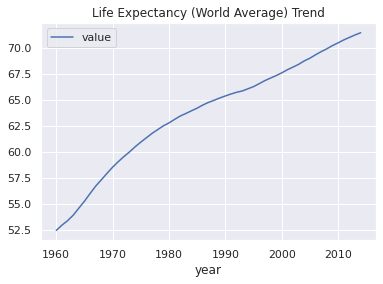

In [69]:
df_le_world = df_le_wide[(df_le_wide["country_name"] == "World")]
df_le_world.plot(x = 'year' , y = 'value', figsize=(6, 4))
plt.title("Life Expectancy (World Average) Trend")
plt.show()

### How have life expectancy across countries changed since 1960?

Next, we checked distribution of life expectacy across countries by year from 1960 to 2015. From the graph below, we can see not only did life expectancy increased over time, variance across countries also decreased over time.

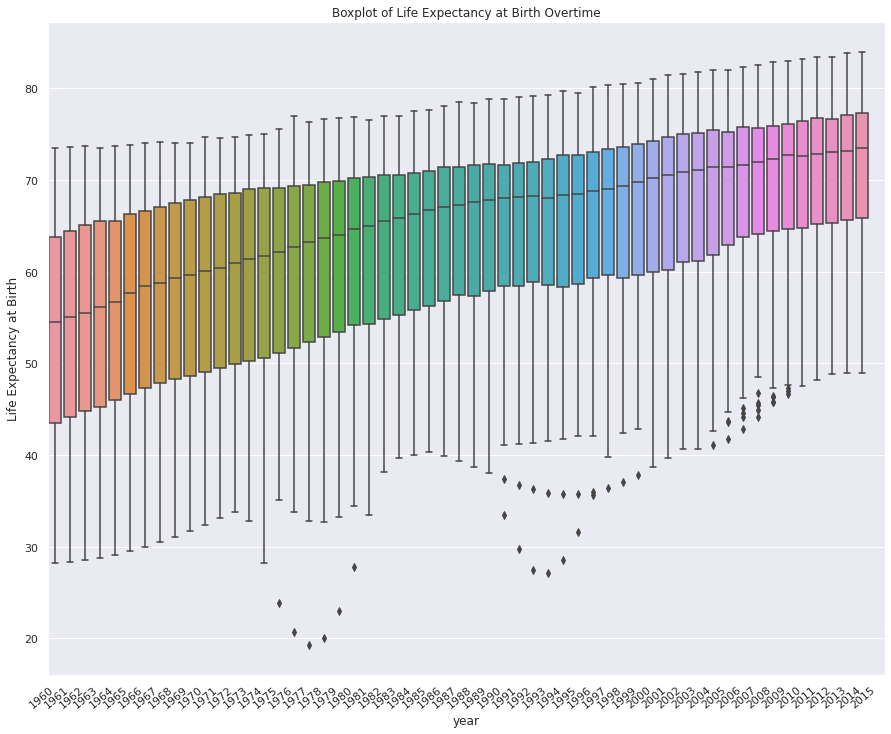

In [70]:
# check non country level rows
df_le_all = df_le_wide[df_le_wide.country_name.isin(drop_list) == False]

# plot boxplot to see distribution
plt.figure(figsize=(15,12))
g = sns.boxplot(df_le_all['year'],
            df_le_all["value"])
g.set_title("Boxplot of Life Expectancy at Birth Overtime")
g.set_ylabel("Life Expectancy at Birth")
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
plt.show()

From the graph we can see that life expectancy is not stationary, as it steadily grows overtime. As a result, for the modelling 

# Modeling

Given the high number of features for each country, we used first unsupervised learning to detect patterns within our data. We used k-means clustering and principal component analysis to better understand which countries are most similar and what characteristics differentiate the countries the most. 

In addition, we applied supervised learning with methods including regression, decision tree, and random forest to see what characteristics is most impactful in increasing overall health and well-being as indicated by life expectancy.

## K-Means Cluster

We use K-Means clustering to categorize the countries and draw inferences to inform our investment decisions. We removed countries with >50% null values, applied standard scaler, and imputed the remaining null value using mean. We then used elbow method and silhouette score analysis to suggest the optimal cluster size. Both methods suggested 2 as the optimal cluster number. However, we picked a higher cluster number since we want to understand how countries can be categorized beyond being identified as developed and developing countries. Lastly we ploted our clustering result on a map.

#####Pre-processing 

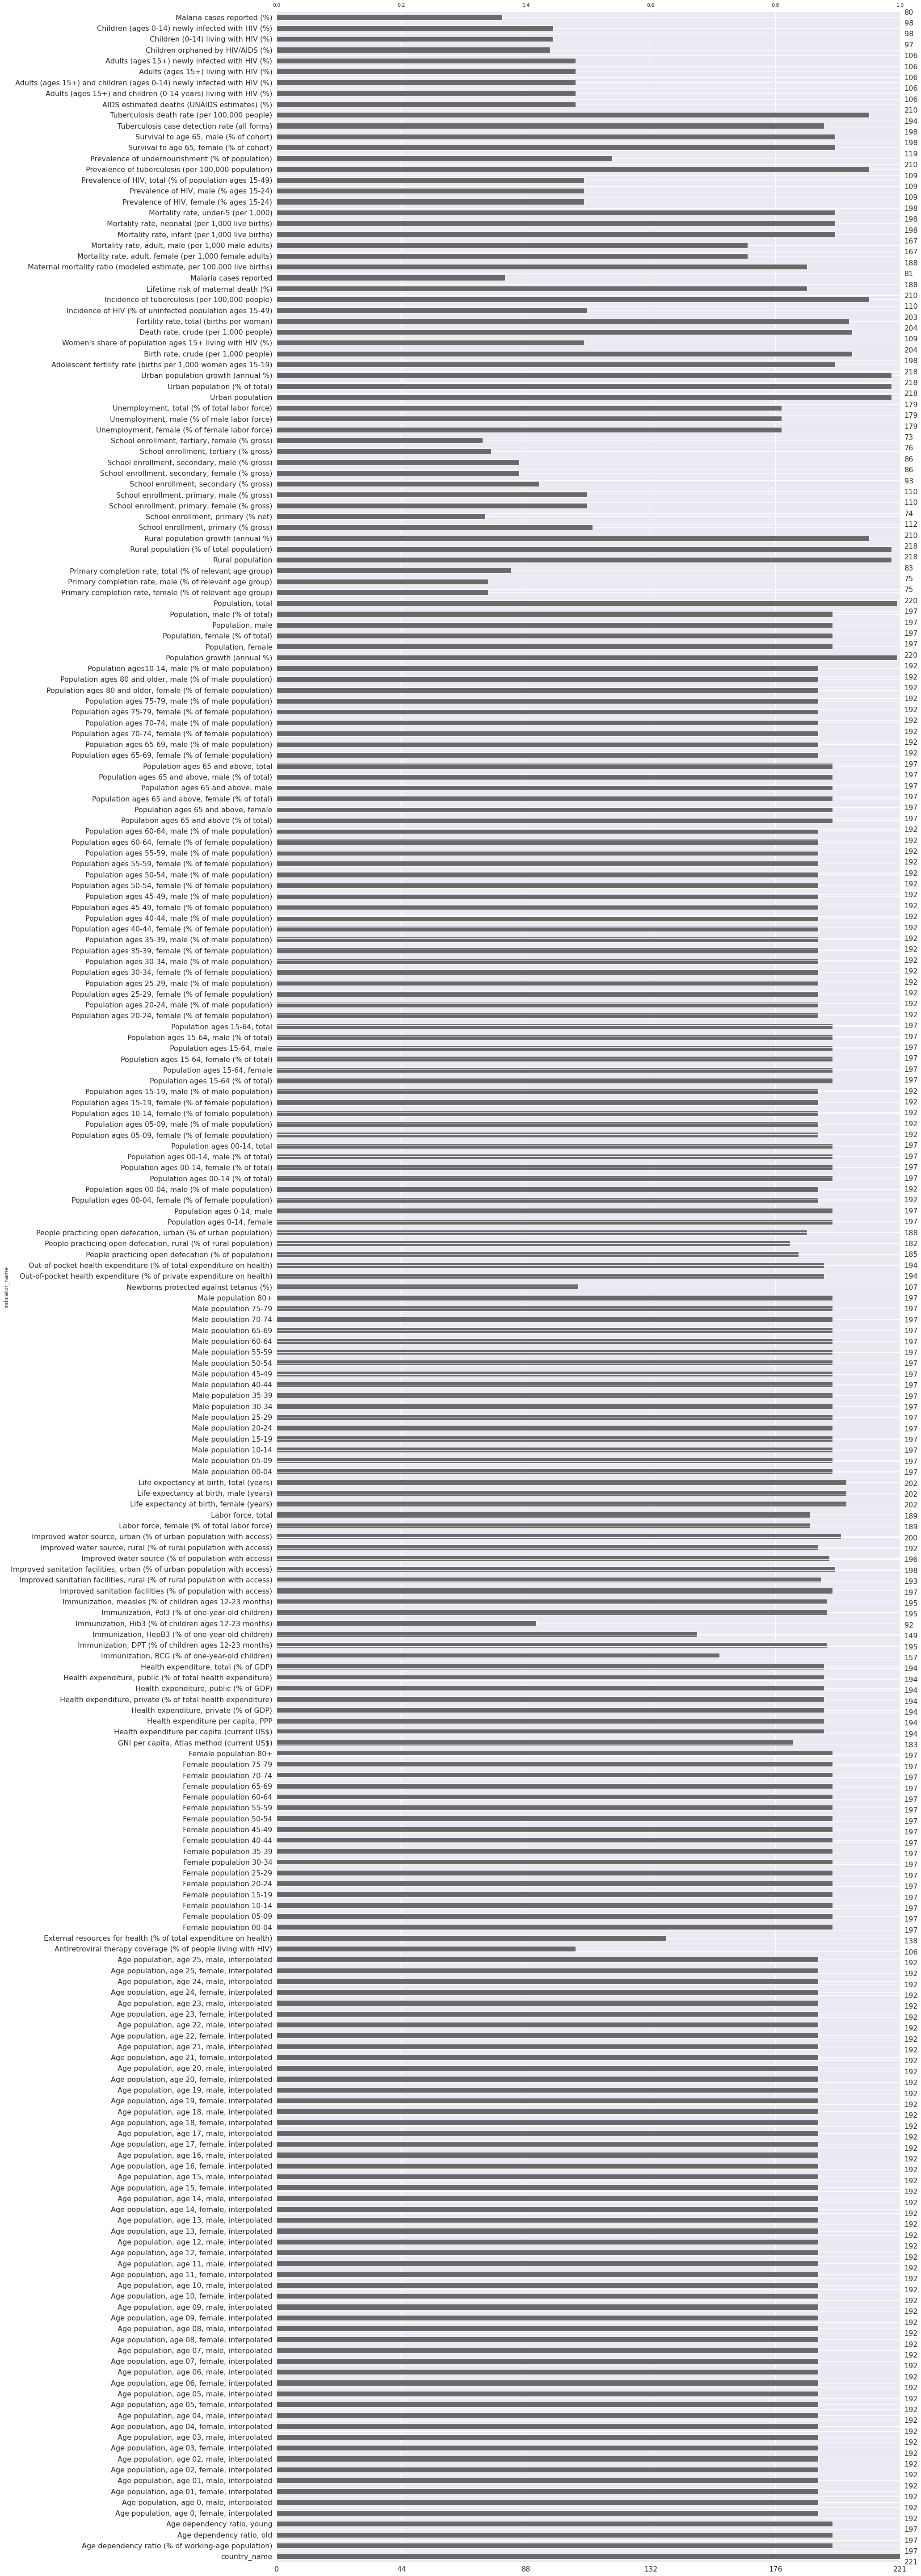

In [71]:
#inspect and analyze distribution of missing value with msno

msno.bar(df_2014_final)

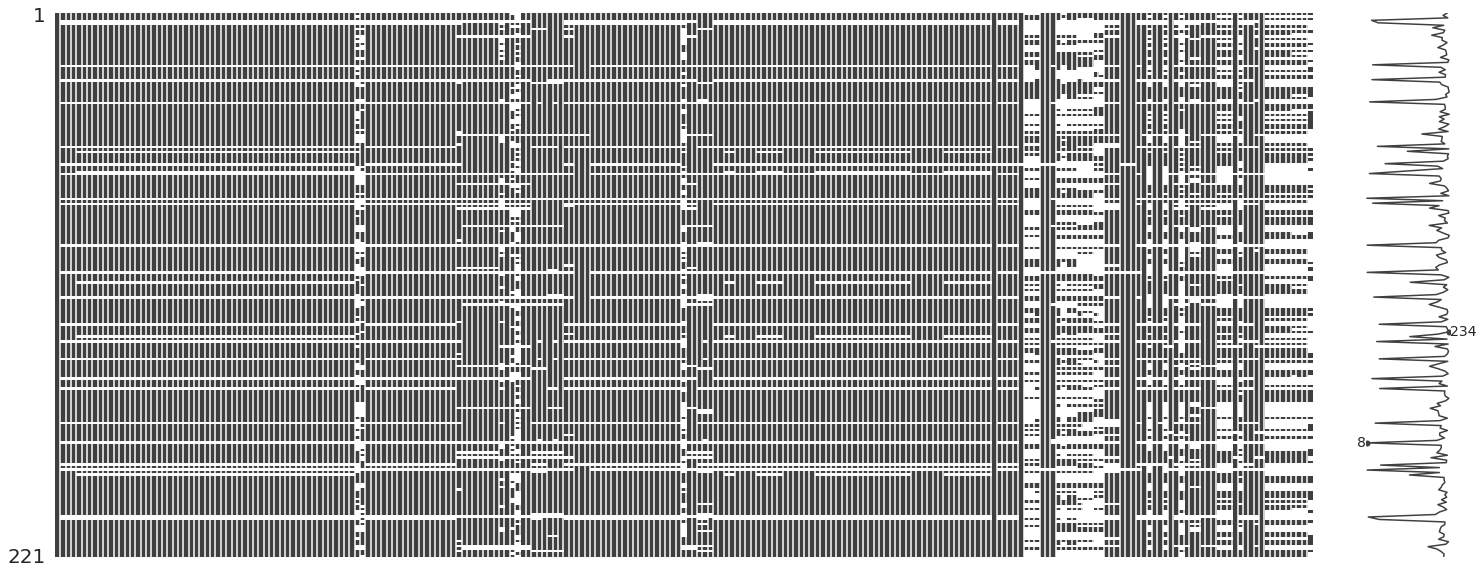

In [72]:
#visualize where data is missing
msno.matrix(df_2014_final)
#graph shows data is not missing based on random, more likely due to unobserved features. 

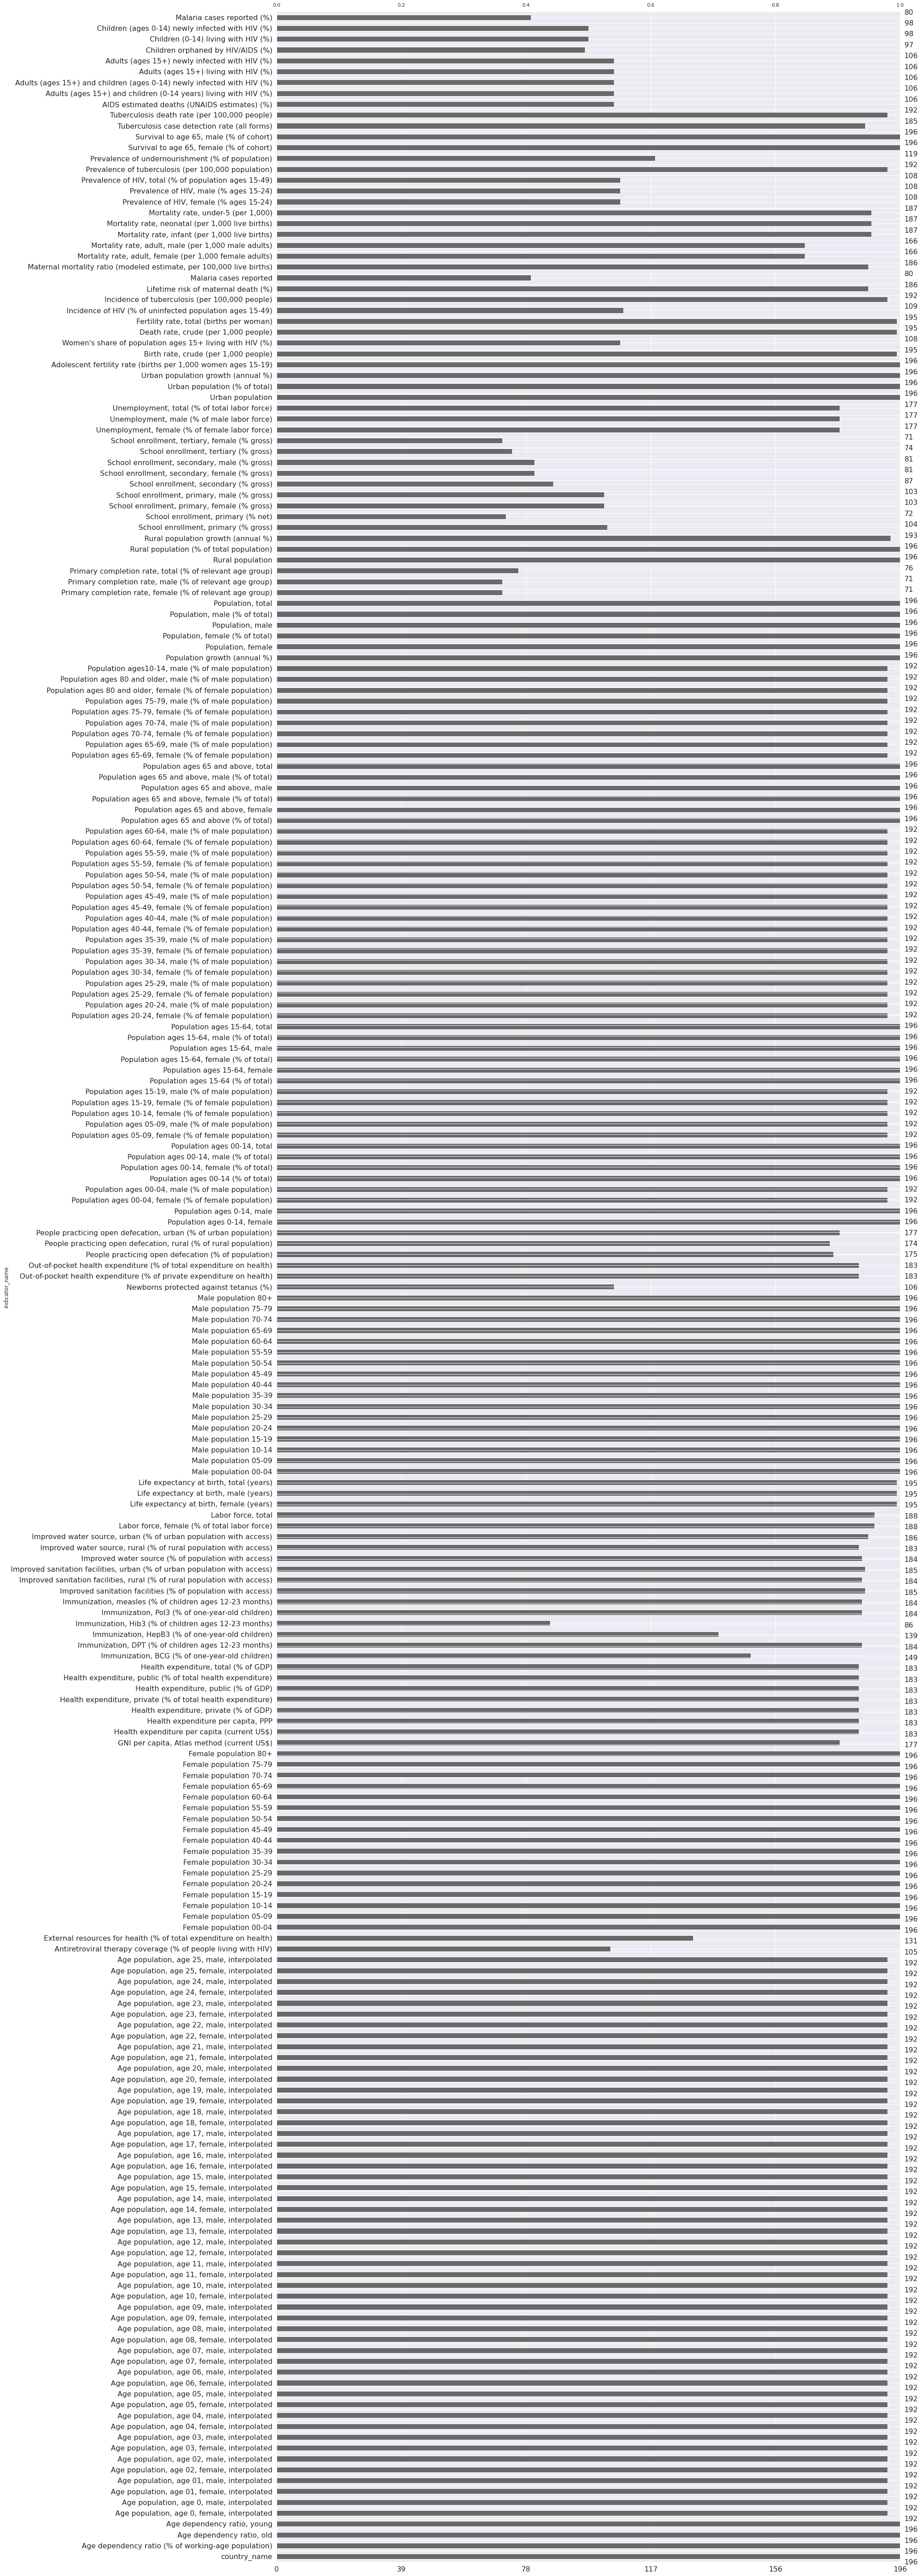

In [73]:
#Dropping rows(countries) with >50% null values and inspect result
#2014
perc = 50.0
min_count =  int(((100-perc)/100)*df_2014_final.shape[1] + 1)
df_2014_kmeans_drop = df_2014_final.dropna(axis=0, thresh=min_count)
msno.bar(df_2014_kmeans_drop)

In [74]:
# Impute missing values using the mean value from n_neighbors nearest neighbors found in the training set.
df_2014_kmeans_temp=df_2014_kmeans_drop.drop('country_name', axis=1)
from sklearn.impute import KNNImputer
imputer = KNNImputer()
df_2014_kmeans_imp = pd.DataFrame(imputer.fit_transform(df_2014_kmeans_temp), columns=df_2014_kmeans_temp.columns)

In [75]:
# Normalize data
from sklearn.preprocessing import StandardScaler
df_2014_kmeans_sc = StandardScaler().fit_transform(df_2014_kmeans_imp)

In [76]:
# determine cluster number with silhouette score analysis
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(df_2014_kmeans_sc)
    sse_.append([k, silhouette_score(df_2014_kmeans_sc, kmeans.labels_)])

#####Determine cluster size

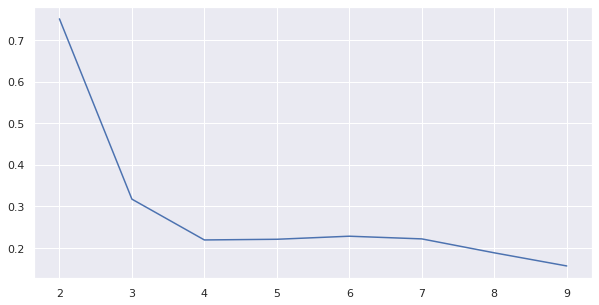

In [77]:
# plot outcome of silhouette score analysis
plt.figure(figsize = (10,5))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.show()

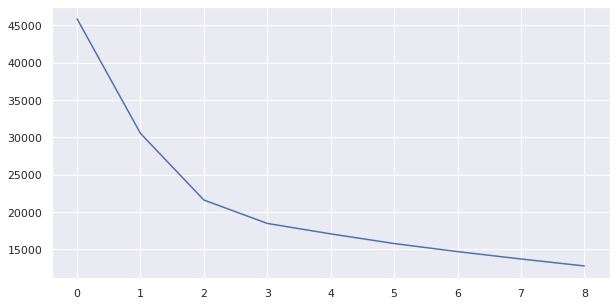

In [78]:
# determine cluster number with elbow method
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(df_2014_kmeans_sc)
    ssd.append(model_clus.inertia_)
plt.figure(figsize = (10,5))
plt.plot(ssd)
plt.show()

#####Model training

In [79]:
kmeans_4 = KMeans(n_clusters = 4, max_iter=50,random_state = 50)
kmeans_4 = kmeans_4.fit(df_2014_kmeans_sc)
label4  = pd.DataFrame(kmeans_4.labels_, columns= ['k_means_cluster_label_4'])

In [80]:
kmeans_3 = KMeans(n_clusters = 3, max_iter=50,random_state = 50)
kmeans_3 = kmeans_3.fit(df_2014_kmeans_sc)
label3  = pd.DataFrame(kmeans_3.labels_, columns= ['k_means_cluster_label_3'])

In [81]:
kmeans_5 = KMeans(n_clusters = 5, max_iter=50,random_state = 50)
kmeans_5 = kmeans_5.fit(df_2014_kmeans_sc)
label5  = pd.DataFrame(kmeans_5.labels_, columns= ['k_means_cluster_label_5'])

In [82]:
# Reset index of original dataset (with values dropped), and glue kmeans label back 
df_2014_kmeans = df_2014_kmeans_drop.copy().reset_index()
df_2014_kmeans['k_means_cluster_label_3']=label3
df_2014_kmeans['k_means_cluster_label_4']=label4
df_2014_kmeans['k_means_cluster_label_5']=label5

#####Output visualization

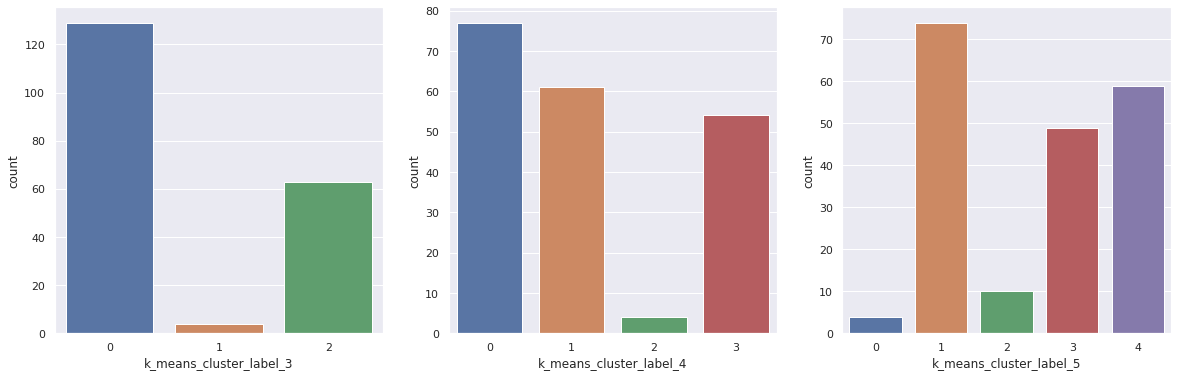

In [83]:
fig, axs = plt.subplots (1, 3, figsize=(20, 6))
sns.countplot(x='k_means_cluster_label_3', data=df_2014_kmeans, ax=axs[0])
sns.countplot(x='k_means_cluster_label_4', data=df_2014_kmeans, ax=axs[1])
sns.countplot(x='k_means_cluster_label_5', data=df_2014_kmeans, ax=axs[2])

In [84]:
#Plot kmeans 5 cluster result 
df_2014_kmeans["k_means_cluster_label_5"] = df_2014_kmeans["k_means_cluster_label_5"].astype(str)
px.scatter(df_2014_kmeans, x='Life expectancy at birth, total (years)',y='Health expenditure per capita (current US$)', 
           hover_data=['country_name'], 
           color='k_means_cluster_label_5',
           color_discrete_sequence=px.colors.qualitative.G10,)

In [85]:
# add geo code by applying the convert method
df_2014_kmeans['country_code'] = df_2014_kmeans.country_name.apply(lambda x: coco.convert(names=x, to='ISO3', not_found=None))
print(df_2014_kmeans['country_code'])


0      AFG
1      ALB
2      DZA
3      AGO
4      ATG
      ... 
191    VIR
192    PSE
193    YEM
194    ZMB
195    ZWE
Name: country_code, Length: 196, dtype: object


In [86]:
#df_2014_kmeans["k_means_cluster_label_5"] = df_2014_kmeans["k_means_cluster_label_5"].astype(float)
fig = px.choropleth(df_2014_kmeans, locations="country_code",
                    color="k_means_cluster_label_5", # lifeExp is a column of gapminder
                    hover_name="country_name", # column to add to hover information
                    color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

We noticed that geographically close countries are likely to be clustered together. For example, EU countries, central Africa countries, and middle east/Arab world countries belongs to three separate clusters.

Additionally, we noticed that economic status plays a big role. Most developed countries, such as US, Canada, and Japan belong the same cluster as EU countries.

The observation above is inline with our expectation. We also noticed a few countries that are different from our expectation. 

1. French Genenia, Uruguay, Cuba, and Thailand belongs to the same cluster as US and EU countries

2. China and India forms their own cluster. 

3. Cambodia and Papua Genia belongs to the same cluster as central Africa countries, despite their geographic closeness to more developed neighbors. 

Our suggestions in relation to these three observations are: 
1. South America countries can learn from French Genenia, Uruguay, and Cuba whilst South East countries learn from Thailand to invest in health. 
2. China and India can learn from each other/codevelop policies when investing in national health. 
3. Neighboring coutries of Cambodia and Papua Genia can share some of their experience in developing health policies with these two countries. 



## PCA

Given the high number of features (242 columns), we first applied principal component analysis to identify innate structure of the data by extracting characteristics with most information.

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Instantiate and Fit PCA
pca = PCA()
pca.fit(df_2014_kmeans_sc)

PCA()

In [88]:
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(pca.explained_variance_ratio_)

Plotting cummulative explained variance ratio we can see that top 40 variables explain more than 95% of the variance among country level data and with only 10 variables, we can explain more than 80% difference.

Text(0, 0.5, 'Cumulative Percentage')

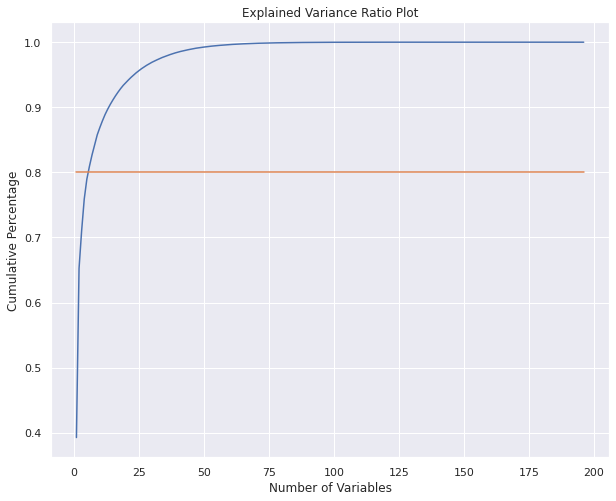

In [89]:
# Plot 
plt.plot(np.arange(1,len(cum_evr)+1), cum_evr)

plt.plot(np.arange(1,len(cum_evr)+1),
         [0.8]*len(np.arange(1,len(cum_evr)+1)))

# Aesthetics
plt.title('Explained Variance Ratio Plot')
plt.xlabel('Number of Variables')
plt.ylabel('Cumulative Percentage')

In [90]:
# Refit and transform on training with parameter n (as deduced from the last step) 
pca = PCA(n_components=20)
components = pca.fit_transform(df_2014_kmeans_sc)

In [91]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    title = "Principal Component Visualization"
)
fig.update_traces(diagonal_visible=False)
fig.show()

From the principal components plot, we can clearly see that PC1 and PC2 combined explain most (65%) of variance in the sample.

## Linear Regression

### For 2014 data only

####Prepare Dataset

Now we will use 2014 data (the most recent and the most complete) to predict life expectancy. Since our goal is to discover features (health indicators) that has the highest effect of life expectancy, we will first need to drop the features that we do not have control over. This include demographic data, mortality rate, etc. 
Now that we only keep the factors that we can influence, our prediction will be meaningful. 

In [92]:
#Remove demographic data from the dataset, and only include factors that we could influence
df_2014_final_lr = df_2014_final[['country_name',
       'Antiretroviral therapy coverage (% of people living with HIV)',
       'External resources for health (% of total expenditure on health)',
       'GNI per capita, Atlas method (current US$)',
       'Health expenditure per capita (current US$)',
       'Health expenditure, private (% of GDP)',
       'Health expenditure, public (% of GDP)',
       'Immunization, BCG (% of one-year-old children)',
       'Immunization, DPT (% of children ages 12-23 months)',
       'Immunization, HepB3 (% of one-year-old children)',
       'Immunization, Hib3 (% of children ages 12-23 months)',
       'Immunization, Pol3 (% of one-year-old children)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Improved sanitation facilities, rural (% of rural population with access)',
       'Improved sanitation facilities, urban (% of urban population with access)',
       'Improved water source, rural (% of rural population with access)',
       'Improved water source, urban (% of urban population with access)',
       'Labor force, female (% of total labor force)',
       'Life expectancy at birth, total (years)', 
       'Newborns protected against tetanus (%)',
       'Out-of-pocket health expenditure (% of total expenditure on health)',
       'People practicing open defecation, rural (% of rural population)',
       'People practicing open defecation, urban (% of urban population)',
       'Population growth (annual %)', 
       'Primary completion rate, female (% of relevant age group)',
       'Primary completion rate, male (% of relevant age group)',
       'School enrollment, primary, female (% gross)',
       'School enrollment, primary, male (% gross)',
       'School enrollment, secondary, female (% gross)',
       'School enrollment, secondary, male (% gross)',
       'School enrollment, tertiary, female (% gross)',
       'Unemployment, female (% of female labor force)',
       'Unemployment, male (% of male labor force)',
       'Urban population growth (annual %)',
       'Birth rate, crude (per 1,000 people)',
       "Women's share of population ages 15+ living with HIV (%)",
       'Incidence of HIV (% of uninfected population ages 15-49)',
       'Incidence of tuberculosis (per 100,000 people)',
       'Lifetime risk of maternal death (%)', 'Malaria cases reported',
       'Prevalence of HIV, female (% ages 15-24)',
       'Prevalence of HIV, male (% ages 15-24)',
       'Prevalence of tuberculosis (per 100,000 population)',
       'Prevalence of undernourishment (% of population)',
       'Tuberculosis case detection rate (all forms)',
       'Tuberculosis death rate (per 100,000 people)',
       'AIDS estimated deaths (UNAIDS estimates) (%)',
       'Adults (ages 15+) living with HIV (%)',
       'Adults (ages 15+) newly infected with HIV (%)',
       'Children orphaned by HIV/AIDS (%)',
       'Children (0-14) living with HIV (%)',
       'Children (ages 0-14) newly infected with HIV (%)',
       'Malaria cases reported (%)']]

First we can take a look at the correlations between the features. Darker colors indicate higher correlations. We can see that the majority of features have a pretty high correlation with the life expectancy. 

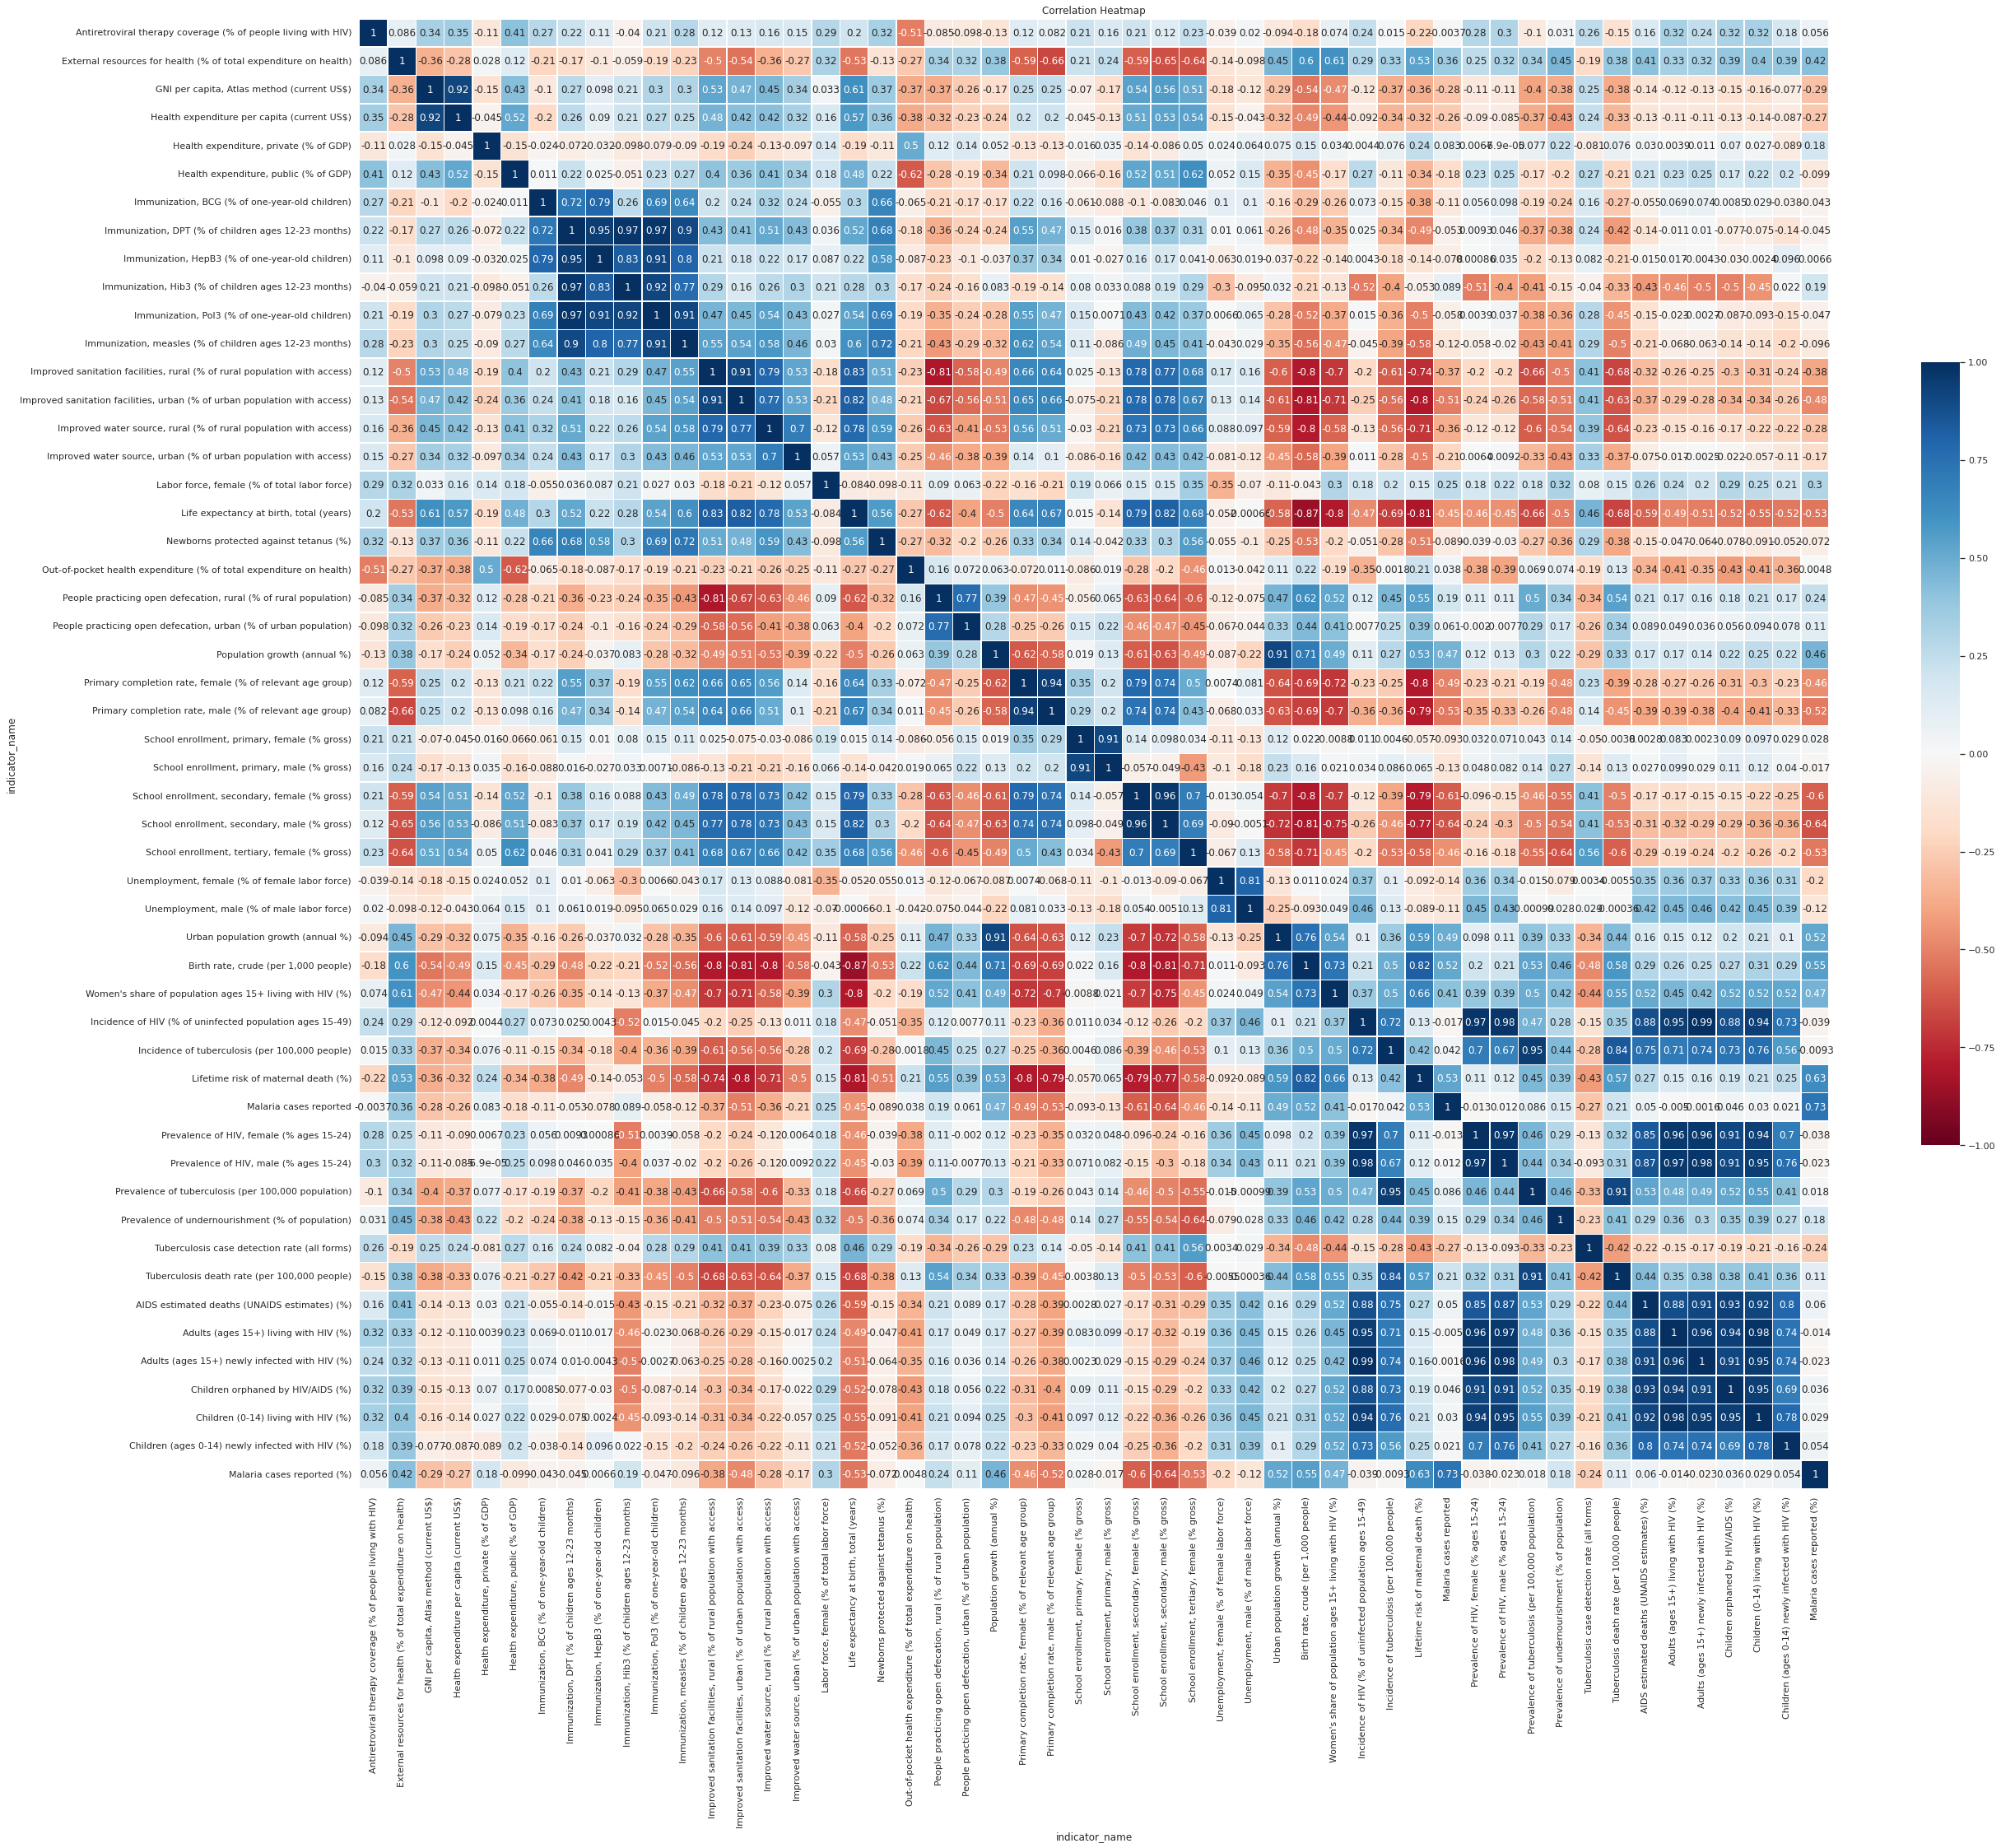

In [93]:
# Plot correlation heatmap for the features that are left
sns.set(rc={'figure.figsize':(40,35)})
heatmap = sns.heatmap(df_2014_final_lr.corr(), cmap="RdBu", vmin=-1, center=0, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlation Heatmap")
heatmap

Now we need to take case of the Null values in the dataset because LinearRegression does not allow Null values. Since we only have ~250 rows of data, cannot afford to drop any. Therefore, we will impute the missing data using mean. 

In [94]:
# Prepare to impute the dataset
df_2014_final_lr_no_country = df_2014_final_lr.drop(columns = ['country_name'])

In [95]:
# Impute the dataset
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')
imputer = imputer.fit(df_2014_final_lr_no_country)
df_2014_final_lr_imputed = pd.DataFrame(imputer.transform(df_2014_final_lr_no_country))
df_2014_final_lr_imputed.columns = df_2014_final_lr_no_country.columns.values

Split into train and test data

In [96]:
# Prepare the dataset and split it into features and label 
# stores features dataframe into variable called "features"
features = df_2014_final_lr_imputed.drop(columns = ['Life expectancy at birth, total (years)'])

# TO-DO: store the regression target variable into "prices"
life_exp = df_2014_final_lr_imputed['Life expectancy at birth, total (years)']

In [97]:
# Split data into train and test 
# Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, life_exp, test_size=0.2, random_state=seed)

####Linear Regression

We run a base case linear regression on the datasets. We can see that the train accuracy score is 0.936, and the test accuracy is about 0.79. This means the model is probably overfitting. 

In [98]:
# Linear Regression
# Import required libraries
from sklearn.linear_model import LinearRegression

# Initialize model with default parameters and fit it on the training set
reg = LinearRegression().fit(x_train, y_train)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(x_test)

# Find the R-squared score and store the value in `score`
score_train = reg.score(x_train, y_train)
score_test = reg.score(x_test, y_test)
print('score_train: ', score_train)
print('score_test: ' , score_test)

score_train:  0.9381470159842832
score_test:  0.8288104108850634


To reduce overfitting, we will now try regularization methods to improve the prediction results

#### Ridge Regression

In [99]:
# TO-DO: Import required libraries
from sklearn.linear_model import Ridge
# TO-DO: Initialize model with alpha = 10 (keep other hyperparameters as default values) and fit it on the training set
reg_ridge = Ridge(alpha=10).fit(x_train, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg_ridge.predict(x_test)

# TO-DO: Find the R-squared score and store the value in `ridge_score`
ridge_score_train = reg_ridge.score(x_train, y_train)
ridge_score_test = reg_ridge.score(x_test, y_test)
print('ridge_score_train: ', ridge_score_train)
print('ridge_score_test: ' , ridge_score_test)

ridge_score_train:  0.930660123808173
ridge_score_test:  0.8558865995666307


#### LASSO 

In [100]:
from sklearn.linear_model import Lasso
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(alpha = 1.0)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(x_train,y_train)
#Predicting for X_test
y_pred =lasso_reg.predict(x_test)
#Printing the Score with RMLSE
lasso_score_train = lasso_reg.score(x_train, y_train)
lasso_score_test = lasso_reg.score(x_test, y_test)
print('lasso_score_train: ', lasso_score_train)
print('lasso_score_test: ' , lasso_score_test)

lasso_score_train:  0.9080442218847187
lasso_score_test:  0.8460914211203729


LASSO regularized model is able to converge the train accuracy and test accuracy. This means we are improving our model. 

#### XGB

Next, we will try XGBoosting model and find out the feature importance, to select the most important factors we should be focusing on. 

In [101]:
# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# define model
xgb = XGBRegressor(n_estimators=100)

xgb.fit(x_train, y_train)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb, features, life_exp, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

[04:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean MAE: 2.223 (0.454)


Below is a list of feature importance output from the XGBoosting model. Based on this, we know that "Lifttime risk of maternal death","Birth rate, crude", "Health expenditure per capita", "Women's share of population ages 15+ living with HIV", "GNI per capita", "Incidence of tuberculosis", "AIDS estimated deaths" are among the most influential factors of life expectancy. 

In [102]:
feature_importance = pd.DataFrame(xgb.feature_importances_, features.columns.values).sort_values(by = 0, ascending = False)
feature_importance.columns = ['feature_importance_score']
feature_importance

feature_importance_score
Lifetime risk of maternal death (%)                                 0.308728
Incidence of tuberculosis (per 100,000 people)                      0.094997
Improved sanitation facilities, rural (% of rur...                  0.091748
Birth rate, crude (per 1,000 people)                                0.091690
Women's share of population ages 15+ living wit...                  0.056567
Prevalence of tuberculosis (per 100,000 populat...                  0.055034
Health expenditure per capita (current US$)                         0.048473
GNI per capita, Atlas method (current US$)                          0.038414
Children (ages 0-14) newly infected with HIV (%)                    0.020318
AIDS estimated deaths (UNAIDS estimates) (%)                        0.016711
Incidence of HIV (% of uninfected population ag...                  0.015554
Tuberculosis death rate (per 100,000 people)                        0.011524
Newborns protected against tetanus (%)                              0.011247
Labor force, female (% of total labor force)                        0.010527
Immunization, Hib3 (% of children ages 12-23 mo...                  0.010163
Malaria cases reported (%)                                          0.008872
Immunization, BCG (% of one-year-old children)                      0.008516
Immunization, DPT (% of children ages 12-23 mon...                  0.007003
Health expenditure, private (% of GDP)                              0.006896
Unemployment, female (% of female labor force)                      0.006333
Population growth (annual %)                                        0.005348
Health expenditure, public (% of GDP)                               0.005093
Improved sanitation facilities, urban (% of urb...                  0.004672
Prevalence of HIV, female (% ages 15-24)                            0.004660
Tuberculosis case detection rate (all forms)                        0.004588
People practicing open defecation, urban (% of ...                  0.004362
Improved water source, urban (% of urban popula...                  0.003667
Immunization, HepB3 (% of one-year-old children)                    0.003558
People practicing open defecation, rural (% of ...                  0.003445
Urban population growth (annual %)                                  0.003379
Adults (ages 15+) newly infected with HIV (%)                       0.003023
Improved water source, rural (% of rural popula...                  0.002958
Prevalence of HIV, male (% ages 15-24)                              0.002953
Immunization, measles (% of children ages 12-23...                  0.002903
School enrollment, tertiary, female (% gross)                       0.002711
Primary completion rate, male (% of relevant ag...                  0.002697
School enrollment, secondary, male (% gross)                        0.002619
Malaria cases reported                                              0.002440
Unemployment, male (% of male labor force)                          0.002109
Immunization, Pol3 (% of one-year-old children)                     0.001901
Antiretroviral therapy coverage (% of people li...                  0.001672
Out-of-pocket health expenditure (% of total ex...                  0.001628
School enrollment, secondary, female (% gross)                      0.001594
School enrollment, primary, male (% gross)                          0.001543
Primary completion rate, female (% of relevant ...                  0.001520
External resources for health (% of total expen...                  0.001507
School enrollment, primary, female (% gross)                        0.001155
Prevalence of undernourishment (% of population)                    0.000978
Adults (ages 15+) living with HIV (%)                               0.000000
Children orphaned by HIV/AIDS (%)                                   0.000000
Children (0-14) living with HIV (%)                                 0.000000

Not that we know the more important features, we will drop the rest of the features and fit the model again, and see if the test accuracy changes. 

In [103]:
features_selected = features[['Lifetime risk of maternal death (%)', 
                              'Birth rate, crude (per 1,000 people)', 
                              'Health expenditure per capita (current US$)', 
                              "Women's share of population ages 15+ living with HIV (%)", 
                              'GNI per capita, Atlas method (current US$)', 
                              'Incidence of tuberculosis (per 100,000 people)', 
                              'AIDS estimated deaths (UNAIDS estimates) (%)', 
                              'Children (ages 0-14) newly infected with HIV (%)',
                              'Unemployment, male (% of male labor force)', 
                              'Immunization, DPT (% of children ages 12-23 months)', 
                              'Newborns protected against tetanus (%)'
                              ]]

In [104]:
# Split data into train and test 
# Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features_selected, life_exp, test_size=0.2, random_state=seed)

In [105]:
from sklearn.linear_model import Lasso
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(alpha = 1.0)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(x_train,y_train)
#Predicting for X_test
y_pred =lasso_reg.predict(x_test)
#Printing the Score with RMLSE
lasso_score_train = lasso_reg.score(x_train, y_train)
lasso_score_test = lasso_reg.score(x_test, y_test)
print('lasso_score_train: ', lasso_score_train)
print('lasso_score_test: ' , lasso_score_test)

lasso_score_train:  0.8763157982444995
lasso_score_test:  0.8188831717547075


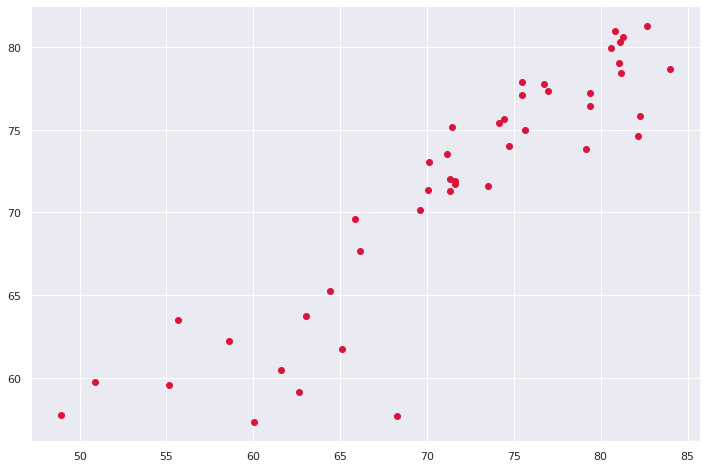

In [106]:
sns.set(rc={'figure.figsize':(12,8)})
plt.scatter(y_test, y_pred, c='crimson')
plt.show()

With only 11 features, the model was able to achieve a prediction as good as before. We also noticed that the prediction of higer life expectancy is better than low life expectancy. 
Therefore, we have high confidence to say that these 11 features are the most important to predict life expectancy. 


1. Lifetime risk of maternal death (%)
2. Birth rate, crude (per 1,000 people)
3. Health expenditure per capita (current US dollars)
4. Womens share of population ages 15+ living with HIV (%)
5. GNI per capita, Atlas method (current US$)
6. Incidence of tuberculosis (per 100,000 people)
8. Children (ages 0-14) newly infected with HIV (%)
9. Unemployment, male (% of male labor force)
10. Immunization, DPT (% of children ages 12-23 months)
11. Newborns protected against tetanus (%)

## Decision Tree

After linear regression falls short to capture the model (lower accuracy for life expectancy <75 as shown in scatterplot), we look at models that are non-linear. Especially given Dayanikli, Gokare, and Kincaid's paper "[Effect of GDP Per Capita on National Life Expectancy](https://smartech.gatech.edu/bitstream/handle/1853/56031/effect_of_gdp_per_capita_on_national_life_expectancy.pdf)" found the impact of GDP on health status is not linear, we want to apply machine learning algorithms that can accomodate non-linear relations. Decision tree is a one of the most popular and accurate model classifiers for big data. Decision tree regressor can capture both linear and non-linear relationships between feature and label. 

We continued to use the data set with imputed values from k-means model and experiemented with different hyperparameters (max_depth = 2 vs. max_depth = 4) to test model fit.

In [109]:
# create feature and label set

features = df_2014_final_lr_imputed.drop(columns = ['Life expectancy at birth, total (years)'])

labels = df_2014_final_lr_imputed['Life expectancy at birth, total (years)']

#labels = df_2014_kmeans_imp['Life expectancy at birth, total (years)']
#features = df_2014_kmeans_imp.drop(['Life expectancy at birth, total (years)'], axis = 1)
#features = df_2014_kmeans_imp['GNI per capita, Atlas method (current US$)']

In [110]:
# split train and test dataset
x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.2)
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [111]:
# Import libraries
from sklearn.tree import DecisionTreeRegressor

# Fit regression model
dt1 = DecisionTreeRegressor(max_depth=2)
dt2 = DecisionTreeRegressor(max_depth=4)
dt1.fit(x_train, y_train)
dt2.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [112]:
# Predict
y1 = dt1.predict(x_test)
y2 = dt2.predict(x_test)

In [113]:
# Get accuracy for decision tree with depth of 2
dt1_score = dt1.score(x_test,y_test)
dt1_score

0.6933002697139965

In [114]:
# Get accuracy for decision tree with depth of 4
dt2_score = dt2.score(x_test,y_test)
dt2_score

0.6969997081222354

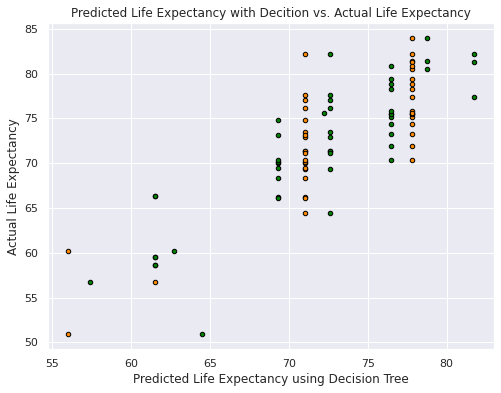

In [115]:
# plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y1, y_test, s=20, edgecolor="black", c="darkorange")
plt.scatter(y2, y_test, s=20, edgecolor="black", c="green")
plt.title("Predicted Life Expectancy with Decition vs. Actual Life Expectancy")
plt.xlabel("Predicted Life Expectancy using Decision Tree")
plt.ylabel("Actual Life Expectancy")
plt.show()

Decision tree models yield high training and testing accuracy. Decision tree with max depth of 4 categorizes countires into more granular groups as shown in the graph above.

##Random Forest Regression

We noticed that decision tree yields lower accuracy than Lasso/Ridge regression, and hence we want to use random forest regression to improve performance. Additionally, wince we want to use ML models for investing decisions, we need to interpret the model in addition to tuning a model for higher accuracy. Hence we implemented a random forst regressor below and calculate the feature importance. This allows us to understand which factors has higher impact on people's life expectancy. We removed all mortality data and demographic data from our feature columns for the regression. Although these datapoints are strong predictors for life expectancy, we can draw limited insights from them. Lastly, we conducted the model based on female and male life expectancy, since we want to know what are the different factors impacting female vs male life expectancy, allowing us to make more targeted investment decisions.

In [116]:
features = df_2014_final_lr_imputed.drop(columns = ['Life expectancy at birth, total (years)'])

labels = df_2014_final_lr_imputed['Life expectancy at birth, total (years)']

# split train and test dataset
x_train, x_test, y_train, y_test = train_test_split(features,labels,test_size=0.2)
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [117]:
#import library, train 
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators =10, random_state =12)
RFregressor.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=12)

In [118]:
y_predRF = RFregressor.predict(x_test)#predict 

In [123]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
RF_accuracy = r2_score(y_test, y_predRF)
print('Random forest test accuracy with 10 decision trees is ', RF_accuracy)
#RF_cm = confusion_matrix(y_test, y_predRF)
#print('Confusion matrix result is', RF_cm)

Random forest test accuracy with 10 decision trees is  0.862109386180737


In [121]:
feature_scores = pd.Series(RFregressor.feature_importances_, index=features.columns).sort_values(ascending=False)

Random forest yields even higher test accuracy of 0.86 (compared to 0.81 of Lasso with XGB), and has high accuracy on the result in all ranges of life expectancy.

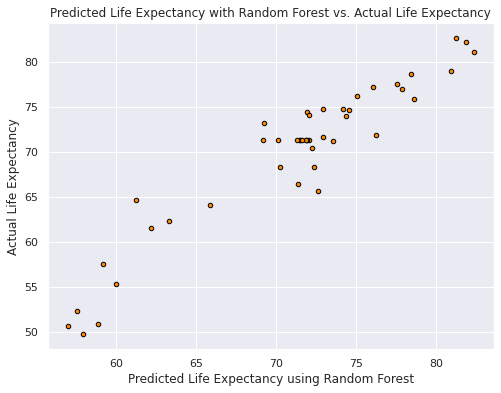

In [122]:
# plot result
plt.figure(figsize=(8, 6))
plt.scatter(y_predRF, y_test, s=20, edgecolor="black", c="darkorange")
plt.title("Predicted Life Expectancy with Random Forest vs. Actual Life Expectancy")
plt.xlabel("Predicted Life Expectancy using Random Forest")
plt.ylabel("Actual Life Expectancy")
plt.show()

### Life expectancy prediction for male vs female

Since random forest regression can produce a high accuracy model, we wonder what are the different factors impacting female vs male life expectancy.

In [126]:
# create feature and label set
labels_RF_female = df_2014_kmeans_imp['Life expectancy at birth, female (years)']
features_RF_female = df_2014_final_lr_imputed.drop(columns = ['Life expectancy at birth, total (years)'])

labels = df_2014_final_lr_imputed['Life expectancy at birth, total (years)']

features_RF_female = df_2014_kmeans_imp.drop(['Life expectancy at birth, total (years)',
                                              'Life expectancy at birth, female (years)', 
                                              'Life expectancy at birth, male (years)',
                                              'Survival to age 65, female (% of cohort)',
                                              'Survival to age 65, male (% of cohort)',
                                              'Mortality rate, adult, female (per 1,000 female adults)',
                           'Mortality rate, adult, male (per 1,000 male adults)',
                           'Mortality rate, infant (per 1,000 live births)',
                           'Mortality rate, neonatal (per 1,000 live births)',
                           'Mortality rate, under-5 (per 1,000)',
                           'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                           'Death rate, crude (per 1,000 people)',
                             'Population ages 0-14, female', 'Population ages 0-14, male',
       'Population ages 00-04, female (% of female population)',
       'Population ages 00-04, male (% of male population)',
       'Population ages 00-14 (% of total)',
       'Population ages 00-14, female (% of total)',
       'Population ages 00-14, male (% of total)',
       'Population ages 00-14, total',
       'Population ages 05-09, female (% of female population)',
       'Population ages 05-09, male (% of male population)',
       'Population ages 10-14, female (% of female population)',
       'Population ages 15-19, female (% of female population)',
       'Population ages 15-19, male (% of male population)',
       'Population ages 15-64 (% of total)',
       'Population ages 15-64, female',
       'Population ages 15-64, female (% of total)',
       'Population ages 15-64, male',
       'Population ages 15-64, male (% of total)',
       'Population ages 15-64, total',
       'Population ages 20-24, female (% of female population)',
       'Population ages 20-24, male (% of male population)',
       'Population ages 25-29, female (% of female population)',
       'Population ages 25-29, male (% of male population)',
       'Population ages 30-34, female (% of female population)',
       'Population ages 30-34, male (% of male population)',
       'Population ages 35-39, female (% of female population)',
       'Population ages 35-39, male (% of male population)',
       'Population ages 40-44, female (% of female population)',
       'Population ages 40-44, male (% of male population)',
       'Population ages 45-49, female (% of female population)',
       'Population ages 45-49, male (% of male population)',
       'Population ages 50-54, female (% of female population)',
       'Population ages 50-54, male (% of male population)',
       'Population ages 55-59, female (% of female population)',
       'Population ages 55-59, male (% of male population)',
       'Population ages 60-64, female (% of female population)',
       'Population ages 60-64, male (% of male population)',
       'Population ages 65 and above (% of total)',
       'Population ages 65 and above, female',
       'Population ages 65 and above, female (% of total)',
       'Population ages 65 and above, male',
       'Population ages 65 and above, male (% of total)',
       'Population ages 65 and above, total',
       'Population ages 65-69, female (% of female population)',
       'Population ages 65-69, male (% of male population)',
       'Population ages 70-74, female (% of female population)',
       'Population ages 70-74, male (% of male population)',
       'Population ages 75-79, female (% of female population)',
       'Population ages 75-79, male (% of male population)',
       'Population ages 80 and older, female (% of female population)',
       'Population ages 80 and older, male (% of male population)',
       'Population ages10-14, male (% of male population)',
       'Population growth (annual %)', 'Population, female',
       'Population, female (% of total)', 'Population, male',
       'Population, male (% of total)', 'Population, total',
       'Age population, age 0, female, interpolated',
       'Age population, age 0, male, interpolated',
       'Age population, age 01, female, interpolated',
       'Age population, age 01, male, interpolated',
       'Age population, age 02, female, interpolated',
       'Age population, age 02, male, interpolated',
       'Age population, age 03, female, interpolated',
       'Age population, age 03, male, interpolated',
       'Age population, age 04, female, interpolated',
       'Age population, age 04, male, interpolated',
       'Age population, age 05, female, interpolated',
       'Age population, age 05, male, interpolated',
       'Age population, age 06, female, interpolated',
       'Age population, age 06, male, interpolated',
       'Age population, age 07, female, interpolated',
       'Age population, age 07, male, interpolated',
       'Age population, age 08, female, interpolated',
       'Age population, age 08, male, interpolated',
       'Age population, age 09, female, interpolated',
       'Age population, age 09, male, interpolated',
       'Age population, age 10, female, interpolated',
       'Age population, age 10, male, interpolated',
       'Age population, age 11, female, interpolated',
       'Age population, age 11, male, interpolated',
       'Age population, age 12, female, interpolated',
       'Age population, age 12, male, interpolated',
       'Age population, age 13, female, interpolated',
       'Age population, age 13, male, interpolated',
       'Age population, age 14, female, interpolated',
       'Age population, age 14, male, interpolated',
       'Age population, age 15, female, interpolated',
       'Age population, age 15, male, interpolated',
       'Age population, age 16, female, interpolated',
       'Age population, age 16, male, interpolated',
       'Age population, age 17, female, interpolated',
       'Age population, age 17, male, interpolated',
       'Age population, age 18, female, interpolated',
       'Age population, age 18, male, interpolated',
       'Age population, age 19, female, interpolated',
       'Age population, age 19, male, interpolated',
       'Age population, age 20, female, interpolated',
       'Age population, age 20, male, interpolated',
       'Age population, age 21, female, interpolated',
       'Age population, age 21, male, interpolated',
       'Age population, age 22, female, interpolated',
       'Age population, age 22, male, interpolated',
       'Age population, age 23, female, interpolated',
       'Age population, age 23, male, interpolated',
       'Age population, age 24, female, interpolated',
       'Age population, age 24, male, interpolated',
       'Age population, age 25, female, interpolated',
       'Age population, age 25, male, interpolated',
       'Male population 00-04',
       'Male population 05-09', 'Male population 10-14',
       'Male population 15-19', 'Male population 20-24',
       'Male population 25-29', 'Male population 30-34',
       'Male population 35-39', 'Male population 40-44',
       'Male population 45-49', 'Male population 50-54',
       'Male population 55-59', 'Male population 60-64',
       'Male population 65-69', 'Male population 70-74',
       'Male population 75-79', 'Male population 80+',
       'Female population 00-04', 'Female population 05-09',
       'Female population 10-14', 'Female population 15-19',
       'Female population 20-24', 'Female population 25-29',
       'Female population 30-34', 'Female population 35-39',
       'Female population 40-44', 'Female population 45-49',
       'Female population 50-54', 'Female population 55-59',
       'Female population 60-64', 'Female population 65-69',
       'Female population 70-74', 'Female population 75-79',
       'Female population 80+', 
       'Health expenditure per capita (current US$)',
       'Improved sanitation facilities, rural (% of rural population with access)',
       'Improved sanitation facilities, urban (% of urban population with access)',	
     
                                          ], axis = 1)

In [127]:
# split train and test dataset
x_train, x_test, y_train, y_test = train_test_split(features_RF_female,labels_RF_female,test_size=0.2)
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [128]:
RFregressor.fit(x_train, y_train)
y_predRF = RFregressor.predict(x_test)#predict 
RF_accuracy = r2_score(y_test, y_predRF)
print('Random forest accuracy with 10 decision trees is ', RF_accuracy)

Random forest accuracy with 10 decision trees is  0.8941011378554511


In [129]:
feature_scores_female = pd.Series(RFregressor.feature_importances_, index=features_RF_female.columns).sort_values(ascending=False)
feature_importance_female = pd.DataFrame(RFregressor.feature_importances_, index=features_RF_female.columns,
                                       columns=['feature_importance_female']).sort_values('feature_importance_female', ascending=False).reset_index()
feature_importance_female = feature_importance_female.set_axis(['feature','feature_importance_female'], axis=1)

display(feature_importance_female.head(15))

feature  \
0   Improved sanitation facilities (% of populatio...   
1                 Lifetime risk of maternal death (%)   
2                           Age dependency ratio, old   
3                Birth rate, crude (per 1,000 people)   
4          GNI per capita, Atlas method (current US$)   
5                  Health expenditure per capita, PPP   
6   Women's share of population ages 15+ living wi...   
7                       Urban population (% of total)   
8   Immunization, measles (% of children ages 12-2...   
9      Incidence of tuberculosis (per 100,000 people)   
10  Improved water source, urban (% of urban popul...   
11           Fertility rate, total (births per woman)   
12  Adolescent fertility rate (births per 1,000 wo...   
13  Adults (ages 15+) and children (0-14 years) li...   
14       Tuberculosis death rate (per 100,000 people)   

    feature_importance_female  
0                    0.422791  
1                    0.354718  
2                    0.028351  
3                    0.022638  
4                    0.016862  
5                    0.015657  
6                    0.013503  
7                    0.013108  
8                    0.008930  
9                    0.008576  
10                   0.007651  
11                   0.006748  
12                   0.005525  
13                   0.004700  
14                   0.004066

In [130]:
# create feature and label set
labels_RF_male = df_2014_kmeans_imp['Life expectancy at birth, male (years)']
features_RF_male = df_2014_kmeans_imp.drop(['Life expectancy at birth, total (years)',
                                              'Life expectancy at birth, female (years)', 
                                              'Life expectancy at birth, male (years)',
                                              'Survival to age 65, female (% of cohort)',
                                              'Survival to age 65, male (% of cohort)',
                                              'Mortality rate, adult, female (per 1,000 female adults)',
                           'Mortality rate, adult, male (per 1,000 male adults)',
                           'Mortality rate, infant (per 1,000 live births)',
                           'Mortality rate, neonatal (per 1,000 live births)',
                           'Mortality rate, under-5 (per 1,000)',
                           'Death rate, crude (per 1,000 people)',
                           'Maternal mortality ratio (modeled estimate, per 100,000 live births)',
                             'Population ages 0-14, female', 'Population ages 0-14, male',
       'Population ages 00-04, female (% of female population)',
       'Population ages 00-04, male (% of male population)',
       'Population ages 00-14 (% of total)',
       'Population ages 00-14, female (% of total)',
       'Population ages 00-14, male (% of total)',
       'Population ages 00-14, total',
       'Population ages 05-09, female (% of female population)',
       'Population ages 05-09, male (% of male population)',
       'Population ages 10-14, female (% of female population)',
       'Population ages 15-19, female (% of female population)',
       'Population ages 15-19, male (% of male population)',
       'Population ages 15-64 (% of total)',
       'Population ages 15-64, female',
       'Population ages 15-64, female (% of total)',
       'Population ages 15-64, male',
       'Population ages 15-64, male (% of total)',
       'Population ages 15-64, total',
       'Population ages 20-24, female (% of female population)',
       'Population ages 20-24, male (% of male population)',
       'Population ages 25-29, female (% of female population)',
       'Population ages 25-29, male (% of male population)',
       'Population ages 30-34, female (% of female population)',
       'Population ages 30-34, male (% of male population)',
       'Population ages 35-39, female (% of female population)',
       'Population ages 35-39, male (% of male population)',
       'Population ages 40-44, female (% of female population)',
       'Population ages 40-44, male (% of male population)',
       'Population ages 45-49, female (% of female population)',
       'Population ages 45-49, male (% of male population)',
       'Population ages 50-54, female (% of female population)',
       'Population ages 50-54, male (% of male population)',
       'Population ages 55-59, female (% of female population)',
       'Population ages 55-59, male (% of male population)',
       'Population ages 60-64, female (% of female population)',
       'Population ages 60-64, male (% of male population)',
       'Population ages 65 and above (% of total)',
       'Population ages 65 and above, female',
       'Population ages 65 and above, female (% of total)',
       'Population ages 65 and above, male',
       'Population ages 65 and above, male (% of total)',
       'Population ages 65 and above, total',
       'Population ages 65-69, female (% of female population)',
       'Population ages 65-69, male (% of male population)',
       'Population ages 70-74, female (% of female population)',
       'Population ages 70-74, male (% of male population)',
       'Population ages 75-79, female (% of female population)',
       'Population ages 75-79, male (% of male population)',
       'Population ages 80 and older, female (% of female population)',
       'Population ages 80 and older, male (% of male population)',
       'Population ages10-14, male (% of male population)',
       'Population growth (annual %)', 'Population, female',
       'Population, female (% of total)', 'Population, male',
       'Population, male (% of total)', 'Population, total',
       'Age population, age 0, female, interpolated',
       'Age population, age 0, male, interpolated',
       'Age population, age 01, female, interpolated',
       'Age population, age 01, male, interpolated',
       'Age population, age 02, female, interpolated',
       'Age population, age 02, male, interpolated',
       'Age population, age 03, female, interpolated',
       'Age population, age 03, male, interpolated',
       'Age population, age 04, female, interpolated',
       'Age population, age 04, male, interpolated',
       'Age population, age 05, female, interpolated',
       'Age population, age 05, male, interpolated',
       'Age population, age 06, female, interpolated',
       'Age population, age 06, male, interpolated',
       'Age population, age 07, female, interpolated',
       'Age population, age 07, male, interpolated',
       'Age population, age 08, female, interpolated',
       'Age population, age 08, male, interpolated',
       'Age population, age 09, female, interpolated',
       'Age population, age 09, male, interpolated',
       'Age population, age 10, female, interpolated',
       'Age population, age 10, male, interpolated',
       'Age population, age 11, female, interpolated',
       'Age population, age 11, male, interpolated',
       'Age population, age 12, female, interpolated',
       'Age population, age 12, male, interpolated',
       'Age population, age 13, female, interpolated',
       'Age population, age 13, male, interpolated',
       'Age population, age 14, female, interpolated',
       'Age population, age 14, male, interpolated',
       'Age population, age 15, female, interpolated',
       'Age population, age 15, male, interpolated',
       'Age population, age 16, female, interpolated',
       'Age population, age 16, male, interpolated',
       'Age population, age 17, female, interpolated',
       'Age population, age 17, male, interpolated',
       'Age population, age 18, female, interpolated',
       'Age population, age 18, male, interpolated',
       'Age population, age 19, female, interpolated',
       'Age population, age 19, male, interpolated',
       'Age population, age 20, female, interpolated',
       'Age population, age 20, male, interpolated',
       'Age population, age 21, female, interpolated',
       'Age population, age 21, male, interpolated',
       'Age population, age 22, female, interpolated',
       'Age population, age 22, male, interpolated',
       'Age population, age 23, female, interpolated',
       'Age population, age 23, male, interpolated',
       'Age population, age 24, female, interpolated',
       'Age population, age 24, male, interpolated',
       'Age population, age 25, female, interpolated',
       'Age population, age 25, male, interpolated',
       'Male population 00-04',
       'Male population 05-09', 'Male population 10-14',
       'Male population 15-19', 'Male population 20-24',
       'Male population 25-29', 'Male population 30-34',
       'Male population 35-39', 'Male population 40-44',
       'Male population 45-49', 'Male population 50-54',
       'Male population 55-59', 'Male population 60-64',
       'Male population 65-69', 'Male population 70-74',
       'Male population 75-79', 'Male population 80+',
       'Female population 00-04', 'Female population 05-09',
       'Female population 10-14', 'Female population 15-19',
       'Female population 20-24', 'Female population 25-29',
       'Female population 30-34', 'Female population 35-39',
       'Female population 40-44', 'Female population 45-49',
       'Female population 50-54', 'Female population 55-59',
       'Female population 60-64', 'Female population 65-69',
       'Female population 70-74', 'Female population 75-79',
       'Female population 80+',
       'Health expenditure per capita (current US$)',
       'Improved sanitation facilities, rural (% of rural population with access)',
       'Improved sanitation facilities, urban (% of urban population with access)'	

                                             
                                              ], axis = 1)

In [131]:
# split train and test dataset
x_train, x_test, y_train, y_test = train_test_split(features_RF_male,labels_RF_male,test_size=0.2)
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [132]:
RFregressor.fit(x_train, y_train)
y_predRF = RFregressor.predict(x_test)#predict 
RF_accuracy = r2_score(y_test, y_predRF)
print('Random forest accuracy with 10 decision trees is ', RF_accuracy)

Random forest accuracy with 10 decision trees is  0.7939598233081518


In [133]:
feature_importance_male = pd.DataFrame(RFregressor.feature_importances_, index=features_RF_male.columns,
                                       columns=['feature_importance_male']).sort_values('feature_importance_male', ascending=False).reset_index()
feature_importance_male = feature_importance_male.set_axis(['feature','feature_importance_male'], axis=1)

pd.set_option('display.precision', 3)
display(feature_importance_male.head(15))

feature  feature_importance_male
0                 Lifetime risk of maternal death (%)                    0.535
1   Improved sanitation facilities (% of populatio...                    0.137
2                  Health expenditure per capita, PPP                    0.131
3   Women's share of population ages 15+ living wi...                    0.029
4          GNI per capita, Atlas method (current US$)                    0.018
5   Primary completion rate, female (% of relevant...                    0.018
6   Improved water source (% of population with ac...                    0.010
7        AIDS estimated deaths (UNAIDS estimates) (%)                    0.008
8            Rural population (% of total population)                    0.007
9        Unemployment, total (% of total labor force)                    0.006
10  Prevalence of tuberculosis (per 100,000 popula...                    0.005
11       Tuberculosis death rate (per 100,000 people)                    0.005
12                Children (0-14) living with HIV (%)                    0.004
13                      Urban population (% of total)                    0.004
14  Antiretroviral therapy coverage (% of people l...                    0.004

In [134]:
feature_importance=feature_importance_female.merge(feature_importance_male, how='left', on='feature')

feature_importance=feature_importance.head(15)

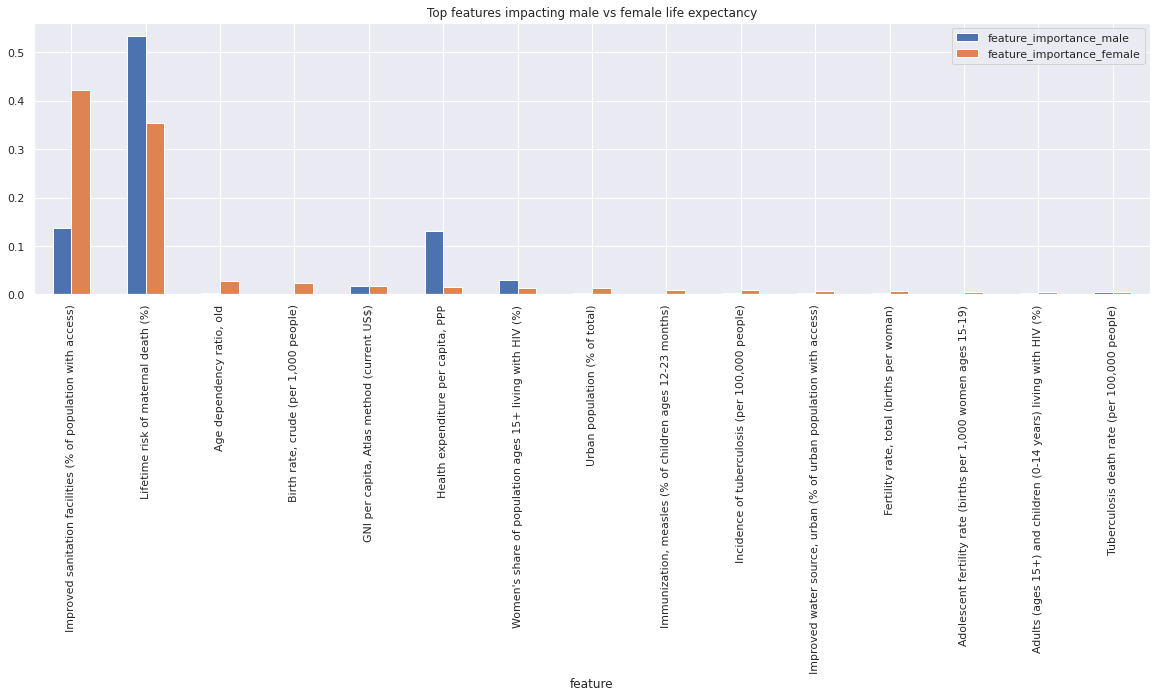

In [135]:
# plot the dataframe
#plt.figure(figsize=(20, 5))
feature_importance.plot(x="feature", y=["feature_importance_male", "feature_importance_female"], kind="bar", figsize=(20,5))
plt.title('Top features impacting male vs female life expectancy')
# print bar graph

plt.show()

Based on the result, we noticed that life time risk of maternal death has the large impact on both female and male life expectancy. According to further research, complications during pregnancy affect both women and the newborns, hence it affects both male and female life expectancy. The top 5 most important feature for female life expectancy are 1. Improved sanitation facilities, 2. Lifetime risk of maternal death, 3.	Age dependency ratio, 4. Birth rate, crude, 5. GNI per capita. The top 5 most important feature for male life expectancy are 1. Lifetime risk of maternal death, 2. Improved sanitation facilities, 3. Health expenditure per capita, 4. Women's share of population ages 15+ living with AIDS and 5. GNI per capita.



# Conclusion

After diving deep into the economic, demographic, and health status of each country and isolating factors that is beyond our investment horizon, we arrive at a few key conclusions. At the outset, our goal was to identify and opportunities for investment to improve life expectancy. We noticed that over the past decade, life expectancy has increased for all countries and the standard deviation in life expectancy amongst different countries has decreased. However, there are still opportunities to close the gap between life expectancies between different countries. Our recommendations are:

1. Whilst gross economic factors and health expenditures are significant factors impacting life expectancy, they are not the only factors that impacts life expectancy. This gives us opportunity to invest in health, other than waiting for countries to develop their economies, before investing in health.
2. Based on the top 11 features identified from regularized linear regression, the areas of health we can invest in are 1. reducing risk of maternal death, 2. limit women and children living with AIDs, 3. immunization program for children, including DPT and tetanus, and 4. increase in health expenditure. 
3. There are common factors that impacts both male and female life expectancy, such as life time risk of maternity death. There are also factors that impacts the life expectancy of one gender more than the other, such as improved sanitation facility. Hence it is important to make more targeted goals before making investing decisions.
4. Countries present different characteristics. There are developing countries (e.g. Cuba and Thailand) that share similar characteristics as developed countries. There are also countries that belong to different cluster despite their proximity with more developed neighbors (e.g. Papua Genia and Cambodia). We recommend the latter group of countries as an opportunity for health investment.

## Citation

1. https://www.kaggle.com/code/prasunapokharel/life-expectancy-from-scratch-who

2. https://www.kaggle.com/code/mathchi/life-expectancy-who-with-several-ml-techniques#Life-Expectancy-(WHO)

3. Impact of GDP per Capital on Life Expectation: https://smartech.gatech.edu/bitstream/handle/1853/56031/effect_of_gdp_per_capita_on_national_life_expectancy.pdf

4. Health at a Glance 2017 https://www.oecd-ilibrary.org/docserver/health_glance-2017-5-en.pdf?expires=1670526046&id=id&accname=guest&checksum=A609E4B20E29C0AF70DBF286F948DCE8

5. Simple measures could increase life expectancy by 5-10 years https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1124540/

6. https://aforanalysis.wordpress.com/2021/02/11/clustering-countries-based-on-socio-economic-and-health-factors/

7. https://www.who.int/news-room/fact-sheets/detail/maternal-mortality#:~:text=A%20woman's%20lifetime%20risk%20of,45%20in%20low%20income%20countries.